## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

In [1]:
!pip install phik
!pip install --upgrade phik

     |████████████████████████████████| 677 kB 2.2 MB/s eta 0:00:01


In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVR
import phik
from phik import report
from phik.phik import phik_matrix
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance



## 1.Загрузка данных и первичный осмотр

In [3]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [4]:
def analyze_dataframe(df, name):
    print(f"\n{'='*50}")
    print(f"Анализ: {name}")
    print(f"{'='*50}")
    print(f"Размер: {df.shape}")
    print(f"\nТипы данных:")
    print(df.dtypes)
    print(f"\nПропуски:")
    print(df.isnull().sum())
    print(f"\nПервые 5 строк:")
    display(df.head())
    print(f"\nБазовая статистика:")
    display(df.describe())

In [5]:
analyze_dataframe(data_arc, "data_arc_new (Нагрев дугой)")
analyze_dataframe(data_bulk, "data_bulk_new (Сыпучие материалы - объем)")
analyze_dataframe(data_bulk_time, "data_bulk_time_new (Сыпучие материалы - время)")
analyze_dataframe(data_gas, "data_gas_new (Продувка газом)")
analyze_dataframe(data_temp, "data_temp_new (Температура)")
analyze_dataframe(data_wire, "data_wire_new (Проволочные материалы - объем)")
analyze_dataframe(data_wire_time, "data_wire_time_new (Проволочные материалы - время)")


Анализ: data_arc_new (Нагрев дугой)
Размер: (14876, 5)

Типы данных:
key                       int64
Начало нагрева дугой     object
Конец нагрева дугой      object
Активная мощность       float64
Реактивная мощность     float64
dtype: object

Пропуски:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Первые 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Базовая статистика:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Анализ: data_bulk_new (Сыпучие материалы - объем)
Размер: (3129, 16)

Типы данных:
key          int64
Bulk 1     float64
Bulk 2     float64
Bulk 3     float64
Bulk 4     float64
Bulk 5     float64
Bulk 6     float64
Bulk 7     float64
Bulk 8     float64
Bulk 9     float64
Bulk 10    float64
Bulk 11    float64
Bulk 12    float64
Bulk 13    float64
Bulk 14    float64
Bulk 15    float64
dtype: object

Пропуски:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Базовая статистика:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Анализ: data_bulk_time_new (Сыпучие материалы - время)
Размер: (3129, 16)

Типы данных:
key         int64
Bulk 1     object
Bulk 2     object
Bulk 3     object
Bulk 4     object
Bulk 5     object
Bulk 6     object
Bulk 7     object
Bulk 8     object
Bulk 9     object
Bulk 10    object
Bulk 11    object
Bulk 12    object
Bulk 13    object
Bulk 14    object
Bulk 15    object
dtype: object

Пропуски:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



Базовая статистика:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Анализ: data_gas_new (Продувка газом)
Размер: (3239, 2)

Типы данных:
key        int64
Газ 1    float64
dtype: object

Пропуски:
key      0
Газ 1    0
dtype: int64

Первые 5 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Базовая статистика:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Анализ: data_temp_new (Температура)
Размер: (18092, 3)

Типы данных:
key               int64
Время замера     object
Температура     float64
dtype: object

Пропуски:
key                0
Время замера       0
Температура     3427
dtype: int64

Первые 5 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Базовая статистика:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Анализ: data_wire_new (Проволочные материалы - объем)
Размер: (3081, 10)

Типы данных:
key         int64
Wire 1    float64
Wire 2    float64
Wire 3    float64
Wire 4    float64
Wire 5    float64
Wire 6    float64
Wire 7    float64
Wire 8    float64
Wire 9    float64
dtype: object

Пропуски:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Базовая статистика:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Анализ: data_wire_time_new (Проволочные материалы - время)
Размер: (3081, 10)

Типы данных:
key        int64
Wire 1    object
Wire 2    object
Wire 3    object
Wire 4    object
Wire 5    object
Wire 6    object
Wire 7    object
Wire 8    object
Wire 9    object
dtype: object

Пропуски:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Базовая статистика:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Вывод по 1 разделу:
1)Датафрейм Нагрев дугой data_arc_new имеет 14876 записей без пропусков. Содержит данные по ключам которые повторяются всего их 3241, и мощностям активной и реактивной. В значении реактивной мощности содержатся аномалии минимальное значение -715 при среднем 0.43.
2) Датафрейм сыпучие материалы обьем содержит 3129 строк и 16 столбцов, ключ и 15 сыпучих компонентов по разному скомбинированных. Есть компоненты которые используются почти всегда 12,14,15 и всего один раз 8.
3) Датафрейм сыпучие матераилы время содержит дополнение к предыдущему датафрейму у них общий ключ, одинаковое количетсво строк и количество пропусков в сыпучих компанентов.
4)Датафрейм продувка газом имеет 3239 строк и два столбца ключ и газ1 без явных выбросов, однако интерсно проверить его на дубликаты так как строк отличается от предыдущего, может для одного ключа несколько продувок или дубликаты
5)Датафрейм температура имеет 18092 и значения ключа, время замера и температуры, для одного ключа имеется нисколько замеров
6) Датафрейм проволочные матеиалы Обьем содержит 3081 строку и столбцы ключ и 9 проволочных материалов. При этом  восновном использовали 1 материал и 1 раз 5 материал, меньше 100 раз 3,4,5,6,7,8,9
7) Датафрейм проволочные материалы время содержит дополнения к предыдущему датафрейму у них общий ключ, одинаковое количетсво строк и количество пропусков в проволочных материалов.
8) Общим среди всех данных является столбец ключ key всего из 3241, в некоторых данных они повторяются т.к. замеры делались для одной партии. При этом значений используется от 3081 и 3129 до 18092. По некоторым партиям данные отсутсвую 

## 2.Исследовательский анализ и предобработка данных

### 2.1 Обработка данных о нагреве дугой

In [6]:
# Преобразование временных столбцов в datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

# Проверка и удаление полных дубликатов
print("Проверка дубликатов:")
print(f"Полные дубликаты: {data_arc.duplicated().sum()}")
data_arc = data_arc.drop_duplicates()
print(f"Строк после удаления дубликатов: {len(data_arc)}")

# Расчет длительности нагрева
data_arc['Длительность_нагрева_сек'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

# Проверка и обработка аномалий реактивной мощности
print("\nПроверка аномалий реактивной мощности:")
negative_reactive_count = len(data_arc[data_arc['Реактивная мощность'] < 0])
print(f"Отрицательная реактивная мощность: {negative_reactive_count}")

# Замена отрицательных значений реактивной мощности средним по ключу
if negative_reactive_count > 0:
    print("Замена отрицательных значений реактивной мощности...")
    # Вычисляем среднюю реактивную мощность для каждого ключа
    reactive_means = data_arc[data_arc['Реактивная мощность'] >= 0].groupby('key')['Реактивная мощность'].mean()
    
    # Функция для замены отрицательных значений
    def fix_negative_reactive(row):
        if row['Реактивная мощность'] < 0:
            key = row['key']
            if key in reactive_means:
                return reactive_means[key]
            else:
                return 0  # если нет нормальных значений для этого ключа
        return row['Реактивная мощность']
    
    # Применяем замену
    data_arc['Реактивная мощность'] = data_arc.apply(fix_negative_reactive, axis=1)
    print(f"Заменено отрицательных значений: {negative_reactive_count}")

# Расчет полной мощности
data_arc['Полная_мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

# Проверка на аномалии
print("\nПроверка аномалий в данных нагрева:")
print(f"Отрицательная длительность: {len(data_arc[data_arc['Длительность_нагрева_сек'] <= 0])}")
print(f"Отрицательная активная мощность: {len(data_arc[data_arc['Активная мощность'] < 0])}")
print(f"Отрицательная реактивная мощность: {len(data_arc[data_arc['Реактивная мощность'] < 0])}")

# Удаление строк с некорректной длительностью
data_arc_clean = data_arc[data_arc['Длительность_нагрева_сек'] > 0].copy()
print(f"\nУдалено строк с отрицательной длительностью: {len(data_arc) - len(data_arc_clean)}")

# Агрегация по партиям
arc_aggregated = data_arc_clean.groupby('key').agg({
    'Длительность_нагрева_сек': ['sum', 'mean', 'count'],
    'Активная мощность': ['mean', 'max', 'sum'],
    'Реактивная мощность': ['mean', 'max'],
    'Полная_мощность': ['mean', 'max', 'sum']
}).round(2)

# Упрощение названий столбцов
arc_aggregated.columns = ['_'.join(col).strip() for col in arc_aggregated.columns.values]
arc_aggregated = arc_aggregated.reset_index()

print(f"\nАгрегированные данные по нагреву: {arc_aggregated.shape}")
print(f"Уникальных партий: {arc_aggregated['key'].nunique()}")
display(arc_aggregated.head())
display(arc_aggregated.describe())

Проверка дубликатов:
Полные дубликаты: 0
Строк после удаления дубликатов: 14876

Проверка аномалий реактивной мощности:
Отрицательная реактивная мощность: 1
Замена отрицательных значений реактивной мощности...
Заменено отрицательных значений: 1

Проверка аномалий в данных нагрева:
Отрицательная длительность: 0
Отрицательная активная мощность: 0
Отрицательная реактивная мощность: 0

Удалено строк с отрицательной длительностью: 0

Агрегированные данные по нагреву: (3214, 12)
Уникальных партий: 3214


,key,Длительность_нагрева_сек_sum,Длительность_нагрева_сек_mean,Длительность_нагрева_сек_count,Активная мощность_mean,Активная мощность_max,Активная мощность_sum,Реактивная мощность_mean,Реактивная мощность_max,Полная_мощность_mean,Полная_мощность_max,Полная_мощность_sum
0,1,1098.0,219.60,5,0.61,0.87,3.04,0.43,0.64,0.74,1.08,3.72
1,2,811.0,202.75,4,0.53,0.79,2.14,0.36,0.54,0.65,0.96,2.59
2,3,655.0,131.00,5,0.81,1.22,4.06,0.59,0.86,1.00,1.50,5.02
3,4,741.0,185.25,4,0.68,0.89,2.71,0.51,0.65,0.85,1.10,3.40
4,5,869.0,217.25,4,0.56,0.89,2.25,0.42,0.66,0.70,1.11,2.82


,key,Длительность_нагрева_сек_sum,Длительность_нагрева_сек_mean,Длительность_нагрева_сек_count,Активная мощность_mean,Активная мощность_max,Активная мощность_sum,Реактивная мощность_mean,Реактивная мощность_max,Полная_мощность_mean,Полная_мощность_max,Полная_мощность_sum
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.00000
mean,1623.061294,794.579029,172.339291,4.628500,0.661325,0.961640,3.067589,0.486064,0.715330,0.821584,1.197134,3.81108
std,934.739859,332.448622,45.606685,1.608647,0.128360,0.231557,1.208592,0.097671,0.184342,0.160010,0.291093,1.50269
min,1.000000,57.000000,57.000000,1.000000,0.270000,0.270000,0.270000,0.200000,0.200000,0.330000,0.330000,0.33000
25%,817.250000,571.000000,140.000000,4.000000,0.570000,0.800000,2.240000,0.420000,0.582500,0.710000,0.990000,2.78000
50%,1623.500000,770.000000,168.750000,4.000000,0.650000,0.970000,2.980000,0.480000,0.710000,0.810000,1.200000,3.69000
75%,2431.750000,983.000000,200.382500,6.000000,0.740000,1.150000,3.780000,0.540000,0.850000,0.920000,1.430000,4.70000
max,3241.000000,4189.000000,380.000000,16.000000,1.240000,1.460000,12.380000,0.960000,1.270000,1.570000,1.900000,15.29000


### 2.2 Обработка данных о сыпучих материалах

In [7]:
# Объединение данных об объеме и времени подачи сыпучих материалов
bulk_combined = data_bulk.merge(data_bulk_time, on='key', suffixes=('_volume', '_time'))

# Проверка и удаление полных дубликатов
print("Проверка дубликатов:")
print(f"Полные дубликаты: {bulk_combined.duplicated().sum()}")
bulk_combined = bulk_combined.drop_duplicates()
print(f"Строк после удаления дубликатов: {len(bulk_combined)}")


# Список сыпучих материалов
bulk_columns = [f'Bulk {i}' for i in range(1, 16)]

# Замена пропусков на 0 (отсутствие подачи)
for col in bulk_columns:
    bulk_combined[f'{col}_volume'] = bulk_combined[f'{col}_volume'].fillna(0)
    bulk_combined[f'{col}_time'] = bulk_combined[f'{col}_time'].fillna(0)

# Агрегация по партиям
bulk_aggregated = bulk_combined.groupby('key').agg({
    **{f'Bulk {i}_volume': 'sum' for i in range(1, 16)},
    **{f'Bulk {i}_time': ['count', 'sum'] for i in range(1, 16)}
}).round(2)

# Упрощение названий столбцов
bulk_aggregated.columns = ['_'.join(col).strip() for col in bulk_aggregated.columns.values]
bulk_aggregated = bulk_aggregated.reset_index()

# Создание обобщенных признаков
bulk_aggregated['Общий_объем_сыпучих'] = bulk_aggregated[[f'Bulk {i}_volume_sum' for i in range(1, 16)]].sum(axis=1)
bulk_aggregated['Количество_подач_сыпучих'] = bulk_aggregated[[f'Bulk {i}_time_count' for i in range(1, 16)]].sum(axis=1)

print(f"\nАгрегированные данные по сыпучим материалам: {bulk_aggregated.shape}")
display(bulk_aggregated.head())

Проверка дубликатов:
Полные дубликаты: 0
Строк после удаления дубликатов: 3129

Агрегированные данные по сыпучим материалам: (3129, 48)


,key,Bulk 1_volume_sum,Bulk 2_volume_sum,Bulk 3_volume_sum,Bulk 4_volume_sum,Bulk 5_volume_sum,Bulk 6_volume_sum,Bulk 7_volume_sum,Bulk 8_volume_sum,Bulk 9_volume_sum,...,Bulk 12_time_count,Bulk 12_time_sum,Bulk 13_time_count,Bulk 13_time_sum,Bulk 14_time_count,Bulk 14_time_sum,Bulk 15_time_count,Bulk 15_time_sum,Общий_объем_сыпучих,Количество_подач_сыпучих
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,1,2019-05-03 11:24:31,1,0,1,2019-05-03 11:14:50,1,2019-05-03 11:10:43,553.0,15
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,1,2019-05-03 11:53:30,1,0,1,2019-05-03 11:48:37,1,2019-05-03 11:44:39,582.0,15
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,1,2019-05-03 12:27:13,1,0,1,2019-05-03 12:21:01,1,2019-05-03 12:16:16,544.0,15
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,1,2019-05-03 12:58:00,1,0,1,2019-05-03 12:51:11,1,2019-05-03 12:46:36,595.0,15
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,1,2019-05-03 13:30:47,1,0,1,2019-05-03 13:34:12,1,2019-05-03 13:30:47,584.0,15


### 2.3 Обработка данных о проволочных материалах

In [8]:
# Объединение данных об объеме и времени подачи проволочных материалов
wire_combined = data_wire.merge(data_wire_time, on='key', suffixes=('_volume', '_time'))

# Проверка и удаление полных дубликатов
print("Проверка дубликатов:")
print(f"Полные дубликаты: {wire_combined.duplicated().sum()}")
wire_combined = wire_combined.drop_duplicates()
print(f"Строк после удаления дубликатов: {len(wire_combined)}")


# Список проволочных материалов
wire_columns = [f'Wire {i}' for i in range(1, 10)]

# Замена пропусков на 0
for col in wire_columns:
    wire_combined[f'{col}_volume'] = wire_combined[f'{col}_volume'].fillna(0)
    wire_combined[f'{col}_time'] = wire_combined[f'{col}_time'].fillna(0)

# Агрегация по партиям
wire_aggregated = wire_combined.groupby('key').agg({
    **{f'Wire {i}_volume': 'sum' for i in range(1, 10)},
    **{f'Wire {i}_time': ['count', 'sum'] for i in range(1, 10)}
}).round(2)

# Упрощение названий столбцов
wire_aggregated.columns = ['_'.join(col).strip() for col in wire_aggregated.columns.values]
wire_aggregated = wire_aggregated.reset_index()

# Создание обобщенных признаков
wire_aggregated['Общий_объем_проволоки'] = wire_aggregated[[f'Wire {i}_volume_sum' for i in range(1, 10)]].sum(axis=1)
wire_aggregated['Количество_подач_проволоки'] = wire_aggregated[[f'Wire {i}_time_count' for i in range(1, 10)]].sum(axis=1)

print(f"\nАгрегированные данные по проволочным материалам: {wire_aggregated.shape}")
display(wire_aggregated.head())

Проверка дубликатов:
Полные дубликаты: 0
Строк после удаления дубликатов: 3081

Агрегированные данные по проволочным материалам: (3081, 30)


,key,Wire 1_volume_sum,Wire 2_volume_sum,Wire 3_volume_sum,Wire 4_volume_sum,Wire 5_volume_sum,Wire 6_volume_sum,Wire 7_volume_sum,Wire 8_volume_sum,Wire 9_volume_sum,...,Wire 6_time_count,Wire 6_time_sum,Wire 7_time_count,Wire 7_time_sum,Wire 8_time_count,Wire 8_time_sum,Wire 9_time_count,Wire 9_time_sum,Общий_объем_проволоки,Количество_подач_проволоки
0,1,60.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,60.06,9
1,2,96.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,96.05,9
2,3,91.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,91.16,9
3,4,89.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,89.06,9
4,5,89.24,9.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,98.35,9


### 2.4 Обработка данных о продувке газом

In [9]:
# Проверка и удаление полных дубликатов
print("Проверка дубликатов:")
print(f"Полные дубликаты: {data_gas.duplicated().sum()}")
data_gas = data_gas.drop_duplicates()
print(f"Строк после удаления дубликатов: {len(data_gas)}")
# Агрегация данных по газу
gas_aggregated = data_gas.groupby('key').agg({
    'Газ 1': ['sum', 'count', 'mean']
}).round(2)

gas_aggregated.columns = ['_'.join(col).strip() for col in gas_aggregated.columns.values]
gas_aggregated = gas_aggregated.reset_index()
gas_aggregated.rename(columns={'Газ 1_sum': 'Суммарный_объем_газа', 
                              'Газ 1_count': 'Количество_продувок',
                              'Газ 1_mean': 'Средний_объем_газа'}, inplace=True)

print(f"\nАгрегированные данные по газу: {gas_aggregated.shape}")
display(gas_aggregated.head())

Проверка дубликатов:
Полные дубликаты: 0
Строк после удаления дубликатов: 3239

Агрегированные данные по газу: (3239, 4)


,key,Суммарный_объем_газа,Количество_продувок,Средний_объем_газа
0,1,29.75,1,29.75
1,2,12.56,1,12.56
2,3,28.55,1,28.55
3,4,18.84,1,18.84
4,5,5.41,1,5.41


### 2.5 Обработка данных о температуре

In [10]:
# Проверка и удаление полных дубликатов
print("Проверка дубликатов:")
print(f"Полные дубликаты: {data_temp.duplicated().sum()}")
data_temp = data_temp.drop_duplicates()

# Преобразование времени замера
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

# Проверка на аномальные значения температуры
print("Проверка температуры на аномалии:")
print(f"Минимальная температура: {data_temp['Температура'].min()}")
print(f"Максимальная температура: {data_temp['Температура'].max()}")

# Удаление физически невозможных значений
data_temp_clean = data_temp[(data_temp['Температура'] > 1000) & (data_temp['Температура'] < 2000)].copy()

# Сортировка по времени для корректного определения первого и последнего замера
data_temp_clean = data_temp_clean.sort_values(['key', 'Время замера'])

# Создание целевых переменных и агрегированных признаков
temp_aggregated = data_temp_clean.groupby('key').agg({
    'Температура': ['first', 'last', 'max', 'min', 'count'],
    'Время замера': ['first', 'last']
}).round(2)

temp_aggregated.columns = ['_'.join(col).strip() for col in temp_aggregated.columns.values]
temp_aggregated = temp_aggregated.reset_index()

# Переименование столбцов
temp_aggregated.rename(columns={
    'Температура_first': 'Начальная_температура',
    'Температура_last': 'Конечная_температура',
    'Температура_max': 'Максимальная_температура',
    'Температура_min': 'Минимальная_температура',
    'Температура_count': 'Количество_замеров',
    'Время замера_first': 'Время_первого_замера',
    'Время замера_last': 'Время_последнего_замера'
}, inplace=True)

single_measure_mask = temp_aggregated['Количество_замеров'] == 1

temp_aggregated.loc[single_measure_mask, 'Конечная_температура'] = np.nan
temp_aggregated.loc[single_measure_mask, 'Максимальная_температура'] = temp_aggregated.loc[single_measure_mask, 'Начальная_температура']
temp_aggregated.loc[single_measure_mask, 'Минимальная_температура'] = temp_aggregated.loc[single_measure_mask, 'Начальная_температура']

# Расчет времени обработки
temp_aggregated['Время_первого_замера'] = pd.to_datetime(temp_aggregated['Время_первого_замера'])
temp_aggregated['Время_последнего_замера'] = pd.to_datetime(temp_aggregated['Время_последнего_замера'])
temp_aggregated['Время_обработки_сек'] = (temp_aggregated['Время_последнего_замера'] - temp_aggregated['Время_первого_замера']).dt.total_seconds()

# Для партий с одним замером время обработки = 0
temp_aggregated.loc[single_measure_mask, 'Время_обработки_сек'] = 0

# Дополнительно: создаем признак, указывающий на партии с одним замером
temp_aggregated['Один_замер'] = single_measure_mask

print(f"\nАгрегированные данные по температуре: {temp_aggregated.shape}")
print(f"Партий с одним замером температуры: {single_measure_mask.sum()}")

# Показываем примеры партий с одним замером
if single_measure_mask.sum() > 0:
    print("\nПримеры партий с одним замером температуры:")
    display(temp_aggregated[single_measure_mask].head())

print("\nОбщая статистика:")
print(f"Всего партий: {len(temp_aggregated)}")
print(f"Партий с одним замером: {single_measure_mask.sum()} ({single_measure_mask.sum()/len(temp_aggregated)*100:.1f}%)")
print(f"Партий с несколькими замерами: {(~single_measure_mask).sum()} ({(~single_measure_mask).sum()/len(temp_aggregated)*100:.1f}%)")

display(temp_aggregated.head())

Проверка дубликатов:
Полные дубликаты: 0
Проверка температуры на аномалии:
Минимальная температура: 1191.0
Максимальная температура: 1705.0

Агрегированные данные по температуре: (3216, 10)
Партий с одним замером температуры: 741

Примеры партий с одним замером температуры:


,key,Начальная_температура,Конечная_температура,Максимальная_температура,Минимальная_температура,Количество_замеров,Время_первого_замера,Время_последнего_замера,Время_обработки_сек,Один_замер
192,195,1583.0,NaN,1583.0,1583.0,1,2019-05-11 00:01:36,2019-05-11 00:01:36,0.0,True
276,279,1603.0,NaN,1603.0,1603.0,1,2019-05-14 10:13:01,2019-05-14 10:13:01,0.0,True
2477,2500,1539.0,NaN,1539.0,1539.0,1,2019-08-10 14:04:39,2019-08-10 14:04:39,0.0,True
2478,2501,1587.0,NaN,1587.0,1587.0,1,2019-08-10 14:41:14,2019-08-10 14:41:14,0.0,True
2479,2502,1583.0,NaN,1583.0,1583.0,1,2019-08-10 15:39:39,2019-08-10 15:39:39,0.0,True



Общая статистика:
Всего партий: 3216
Партий с одним замером: 741 (23.0%)
Партий с несколькими замерами: 2475 (77.0%)


,key,Начальная_температура,Конечная_температура,Максимальная_температура,Минимальная_температура,Количество_замеров,Время_первого_замера,Время_последнего_замера,Время_обработки_сек,Один_замер
0,1,1571.0,1613.0,1618.0,1571.0,6,2019-05-03 11:02:04,2019-05-03 11:30:38,1714.0,False
1,2,1581.0,1602.0,1604.0,1577.0,5,2019-05-03 11:34:04,2019-05-03 11:55:09,1265.0,False
2,3,1596.0,1599.0,1600.0,1596.0,6,2019-05-03 12:06:44,2019-05-03 12:35:57,1753.0,False
3,4,1601.0,1625.0,1625.0,1601.0,5,2019-05-03 12:39:27,2019-05-03 12:59:47,1220.0,False
4,5,1576.0,1602.0,1602.0,1576.0,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1536.0,False


Вывод по разделу 2:
1) Сразу обьеденим два датафрейма по выпучим и проволоным материалам для удобства
2) В данных отсутсвуют полные дубликаты
3) В данных о нагреву трубой приствует аномалия отрицательная реактивная мощность заменим ее средним значением по партии(key)
4) Данные о нагреву трубой, о продувке газом и даные о температуре агрегируем по партиям(key) для того чтобы в дальнейшем обьединить в одну таблицу

In [11]:
temp_aggregated['Конечная_температура'].isnull().sum()

741

## 3. Объединение данных

In [12]:
# Создание основного датафрейма с уникальными партиями
all_keys = set()
for df in [arc_aggregated, bulk_aggregated, wire_aggregated, gas_aggregated, temp_aggregated]:
    all_keys.update(df['key'].unique())

df_main = pd.DataFrame({'key': list(all_keys)})
print(f"Всего уникальных партий: {len(df_main)}")

# Последовательное объединение всех данных
df_combined = df_main.merge(temp_aggregated, on='key', how='left')
df_combined = df_combined.merge(arc_aggregated, on='key', how='left')
df_combined = df_combined.merge(bulk_aggregated, on='key', how='left')
df_combined = df_combined.merge(wire_aggregated, on='key', how='left')
df_combined = df_combined.merge(gas_aggregated, on='key', how='left')

print(f"\nРазмер объединенного датафрейма: {df_combined.shape}")
print(f"\nСтолбцы объединенного датафрейма:")
print(df_combined.columns.tolist())

Всего уникальных партий: 3241

Размер объединенного датафрейма: (3241, 100)

Столбцы объединенного датафрейма:
['key', 'Начальная_температура', 'Конечная_температура', 'Максимальная_температура', 'Минимальная_температура', 'Количество_замеров', 'Время_первого_замера', 'Время_последнего_замера', 'Время_обработки_сек', 'Один_замер', 'Длительность_нагрева_сек_sum', 'Длительность_нагрева_сек_mean', 'Длительность_нагрева_сек_count', 'Активная мощность_mean', 'Активная мощность_max', 'Активная мощность_sum', 'Реактивная мощность_mean', 'Реактивная мощность_max', 'Полная_мощность_mean', 'Полная_мощность_max', 'Полная_мощность_sum', 'Bulk 1_volume_sum', 'Bulk 2_volume_sum', 'Bulk 3_volume_sum', 'Bulk 4_volume_sum', 'Bulk 5_volume_sum', 'Bulk 6_volume_sum', 'Bulk 7_volume_sum', 'Bulk 8_volume_sum', 'Bulk 9_volume_sum', 'Bulk 10_volume_sum', 'Bulk 11_volume_sum', 'Bulk 12_volume_sum', 'Bulk 13_volume_sum', 'Bulk 14_volume_sum', 'Bulk 15_volume_sum', 'Bulk 1_time_count', 'Bulk 1_time_sum', 'Bulk 

Вывод по разделу 3: После обьединения датафреймов по столбцу key получится один с 3241 строками и 100 столбцами. 

## 4.Анализ и предобработка объединённого датафрейма

Анализ пропусков:


,Пропуски,Процент
Конечная_температура,766,23.634681
Количество_подач_проволоки,160,4.936748
Wire 3_time_sum,160,4.936748
Wire 1_volume_sum,160,4.936748
Wire 2_volume_sum,160,4.936748
Wire 3_volume_sum,160,4.936748
Wire 4_volume_sum,160,4.936748
Wire 5_volume_sum,160,4.936748
Wire 6_volume_sum,160,4.936748
Wire 8_volume_sum,160,4.936748


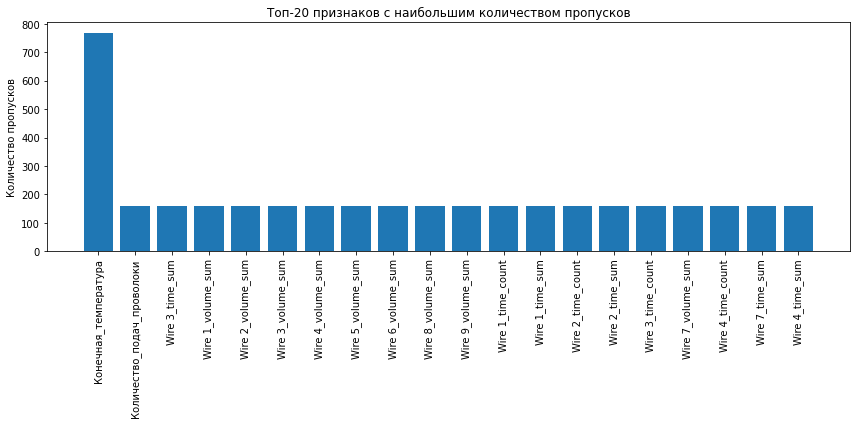

Порог отбрасывания признаков: 30%
Признаков с пропусками ≤ 30%: 99
Признаков с пропусками > 30%: 0

Размер датафрейма после удаления признаков с пропусками > 30%: (3241, 100)
Удалено строк с пропусками в целевой переменной: 766
Удалено строк с пропусками в числовых признаках: 146
Итоговый размер датафрейма: (2329, 100)
Оставшиеся пропуски в данных: 0

Создание новых признаков...
Создано новых признаков: 6


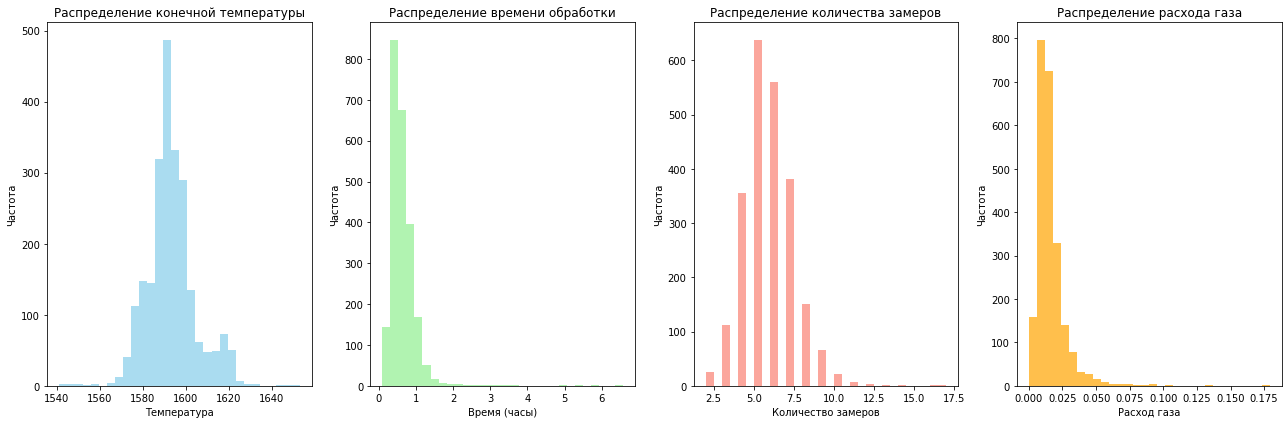

РАСШИРЕННЫЙ КОРРЕЛЯЦИОННЫЙ АНАЛИЗ С ИСПОЛЬЗОВАНИЕМ PHIK
Всего числовых признаков для анализа: 79

Используется матрица корреляции Phik (Phi_K) для всех признаков...
Вычисляем матрицу Phik... Это может занять некоторое время...
✓ Матрица Phik успешно вычислена

Топ-20 признаков по корреляции Phik с конечной температурой (из 49 проанализированных):


,Phik корреляция
Максимальная_температура,0.840337
Bulk 7_volume_sum,0.687430
Wire 4_volume_sum,0.647938
Bulk 2_volume_sum,0.623168
Wire 7_volume_sum,0.599682
Wire 3_volume_sum,0.549163
Wire 6_volume_sum,0.512924
Полная_мощность_sum,0.488620
Активная мощность_sum,0.481956
Wire 1_volume_sum,0.470511



📊 Признак 'Расход_газа': позиция 33, Phik корреляция: 0.175

Признаков с Phik корреляцией > 0.1: 39
Высококоррелирующие признаки:
  1. Максимальная_температура: 0.840
  2. Bulk 7_volume_sum: 0.687
  3. Wire 4_volume_sum: 0.648
  4. Bulk 2_volume_sum: 0.623
  5. Wire 7_volume_sum: 0.600
  6. Wire 3_volume_sum: 0.549
  7. Wire 6_volume_sum: 0.513
  8. Полная_мощность_sum: 0.489
  9. Активная мощность_sum: 0.482
  10. Wire 1_volume_sum: 0.471
  11. Время_обработки_сек: 0.420
  12. Минимальная_температура: 0.399
  13. Длительность_нагрева_сек_count: 0.360
  14. Количество_замеров: 0.360
  15. Bulk 6_volume_sum: 0.349


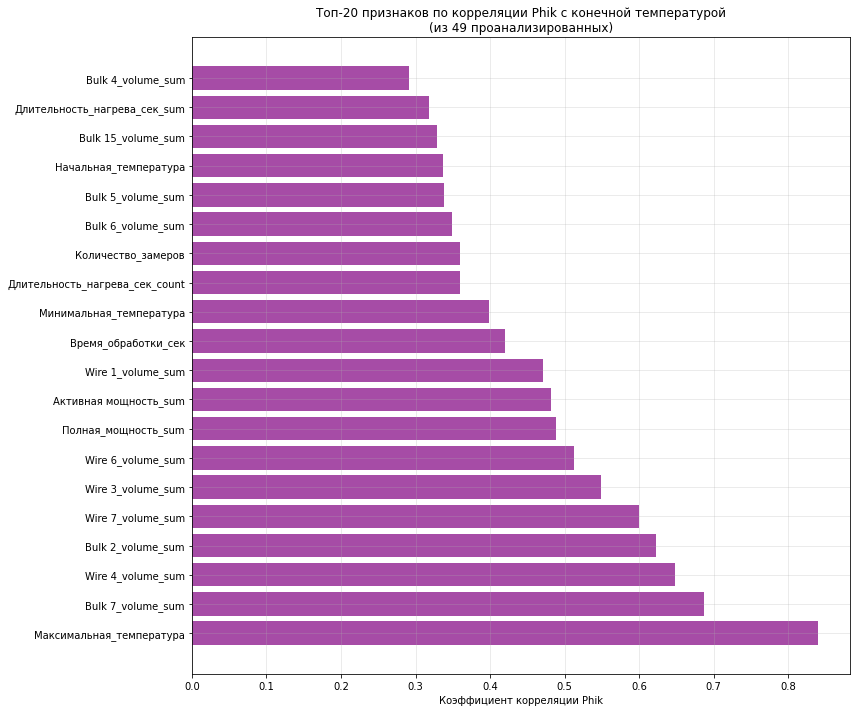


АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ ДЛЯ ВЫСОКОКОРРЕЛИРУЮЩИХ ПРИЗНАКОВ
Признаков для анализа мультиколлинеарности: 30
Вычисляем матрицу Phik... Это может занять некоторое время...


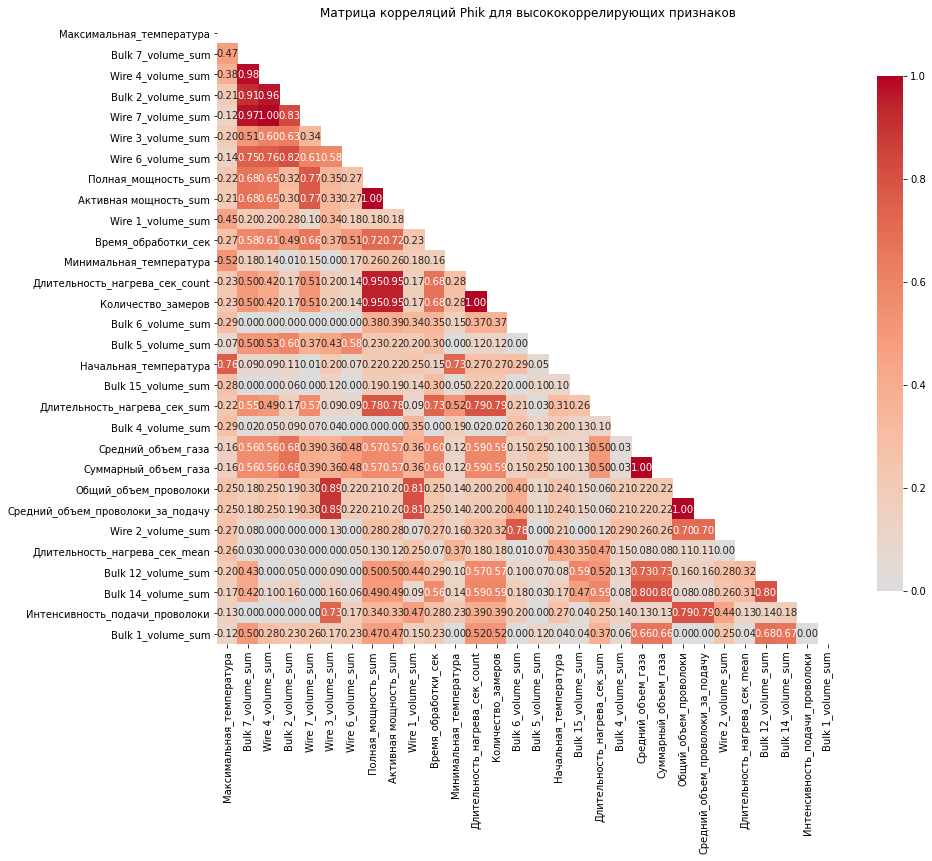


Анализ высоких корреляций между признаками:
Обнаружены высокие корреляции (> 0.7):
  Максимальная_температура <-> Начальная_температура: 0.762
  Bulk 7_volume_sum <-> Wire 4_volume_sum: 0.977
  Bulk 7_volume_sum <-> Bulk 2_volume_sum: 0.912
  Bulk 7_volume_sum <-> Wire 7_volume_sum: 0.973
  Bulk 7_volume_sum <-> Wire 6_volume_sum: 0.746
  Wire 4_volume_sum <-> Bulk 2_volume_sum: 0.964
  Wire 4_volume_sum <-> Wire 7_volume_sum: 0.996
  Wire 4_volume_sum <-> Wire 6_volume_sum: 0.762
  Bulk 2_volume_sum <-> Wire 7_volume_sum: 0.833
  Bulk 2_volume_sum <-> Wire 6_volume_sum: 0.815
  Wire 7_volume_sum <-> Полная_мощность_sum: 0.774
  Wire 7_volume_sum <-> Активная мощность_sum: 0.766
  Wire 3_volume_sum <-> Общий_объем_проволоки: 0.891
  Wire 3_volume_sum <-> Средний_объем_проволоки_за_подачу: 0.891
  Wire 3_volume_sum <-> Интенсивность_подачи_проволоки: 0.730
  Полная_мощность_sum <-> Активная мощность_sum: 1.000
  Полная_мощность_sum <-> Время_обработки_сек: 0.718
  Полная_мощность_sum <

In [13]:
# Анализ пропусков
missing_data = df_combined.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(df_combined)) * 100

print("Анализ пропусков:")
missing_info = pd.DataFrame({'Пропуски': missing_data, 'Процент': missing_percent})
display(missing_info[missing_info['Пропуски'] > 0].head(20))

# Визуализация пропусков
plt.figure(figsize=(12, 6))
missing_plot = missing_data[missing_data > 0]
plt.bar(missing_plot.index[:20], missing_plot.values[:20])
plt.xticks(rotation=90)
plt.title('Топ-20 признаков с наибольшим количеством пропусков')
plt.ylabel('Количество пропусков')
plt.tight_layout()
plt.show()

# Разделим на признаки с малым и большим количеством пропусков
threshold_percent = 30  # 20% порог
low_missing_cols = missing_data[(missing_data > 0) & (missing_percent <= threshold_percent)].index
high_missing_cols = missing_data[missing_percent > threshold_percent].index

print(f"Порог отбрасывания признаков: {threshold_percent}%")
print(f"Признаков с пропусками ≤ {threshold_percent}%: {len(low_missing_cols)}")
print(f"Признаков с пропусками > {threshold_percent}%: {len(high_missing_cols)}")

# Выводим признаки, которые будут отброшены
if len(high_missing_cols) > 0:
    print(f"\nПризнаки с пропусками > {threshold_percent}% (будут удалены):")
    for i, col in enumerate(high_missing_cols, 1):
        print(f"{i:2d}. {col}: {missing_percent[col]:.1f}% пропусков")

# Удаляем признаки с большим количеством пропусков (>20%)
df_clean = df_combined.drop(columns=high_missing_cols)

print(f"\nРазмер датафрейма после удаления признаков с пропусками > {threshold_percent}%: {df_clean.shape}")

# Удаляем строки с пропусками в целевой переменной (если она есть)
if 'Конечная_температура' in df_clean.columns:
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=['Конечная_температура'])
    removed_target_rows = initial_rows - len(df_clean)
    print(f"Удалено строк с пропусками в целевой переменной: {removed_target_rows}")

# Для оставшихся числовых признаков с малым количеством пропусков удаляем строки с пропусками
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
initial_rows = len(df_clean)

# Удаляем строки, где есть пропуски в любом из числовых столбцов
df_clean = df_clean.dropna(subset=numeric_columns)

removed_rows = initial_rows - len(df_clean)
print(f"Удалено строк с пропусками в числовых признаках: {removed_rows}")
print(f"Итоговый размер датафрейма: {df_clean.shape}")

# Проверяем, что пропусков больше нет
remaining_missing = df_clean.isnull().sum().sum()
print(f"Оставшиеся пропуски в данных: {remaining_missing}")

# Дополнительный инжиниринг признаков
print("\nСоздание новых признаков...")

# Интенсивность процессов (проверяем наличие столбцов перед созданием)
new_features_created = 0

if 'Полная_мощность_sum' in df_clean.columns and 'Время_обработки_сек' in df_clean.columns:
    df_clean['Интенсивность_нагрева'] = df_clean['Полная_мощность_sum'] / df_clean['Время_обработки_сек']
    new_features_created += 1

if 'Общий_объем_сыпучих' in df_clean.columns and 'Время_обработки_сек' in df_clean.columns:
    df_clean['Интенсивность_подачи_сыпучих'] = df_clean['Общий_объем_сыпучих'] / df_clean['Время_обработки_сек']
    new_features_created += 1

if 'Общий_объем_проволоки' in df_clean.columns and 'Время_обработки_сек' in df_clean.columns:
    df_clean['Интенсивность_подачи_проволоки'] = df_clean['Общий_объем_проволоки'] / df_clean['Время_обработки_сек']
    new_features_created += 1


if 'Суммарный_объем_газа' in df_clean.columns and 'Длительность_нагрева_сек_sum' in df_clean.columns:
    df_clean['Расход_газа'] = df_clean['Суммарный_объем_газа'] / df_clean['Длительность_нагрева_сек_sum']
    new_features_created += 1
     

# Средние объемы подач
if all(col in df_clean.columns for col in ['Общий_объем_сыпучих', 'Количество_подач_сыпучих']):
    df_clean['Средний_объем_сыпучих_за_подачу'] = df_clean['Общий_объем_сыпучих'] / df_clean['Количество_подач_сыпучих']
    new_features_created += 1

if all(col in df_clean.columns for col in ['Общий_объем_проволоки', 'Количество_подач_проволоки']):
    df_clean['Средний_объем_проволоки_за_подачу'] = df_clean['Общий_объем_проволоки'] / df_clean['Количество_подач_проволоки']
    new_features_created += 1

print(f"Создано новых признаков: {new_features_created}")

# Замена бесконечных значений на 0 (для новых созданных признаков)
df_clean = df_clean.replace([np.inf, -np.inf], 0)

# Визуализация распределения целевой переменной и новых признаков
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.hist(df_clean['Конечная_температура'], bins=30, alpha=0.7, color='skyblue')
plt.title('Распределение конечной температуры')
plt.xlabel('Температура')
plt.ylabel('Частота')

plt.subplot(1, 4, 2)
plt.hist(df_clean['Время_обработки_сек'] / 3600, bins=30, alpha=0.7, color='lightgreen')  # в часах
plt.title('Распределение времени обработки')
plt.xlabel('Время (часы)')
plt.ylabel('Частота')

plt.subplot(1, 4, 3)
plt.hist(df_clean['Количество_замеров'], bins=30, alpha=0.7, color='salmon')
plt.title('Распределение количества замеров')
plt.xlabel('Количество замеров')
plt.ylabel('Частота')

# Визуализация нового признака "Расход газа"
plt.subplot(1, 4, 4)
if 'Расход_газа' in df_clean.columns:
    plt.hist(df_clean['Расход_газа'], bins=30, alpha=0.7, color='orange')
    plt.title('Распределение расхода газа')
    plt.xlabel('Расход газа')
    plt.ylabel('Частота')
else:
    plt.text(0.5, 0.5, 'Признак "Расход_газа"\nне создан', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Расход газа (недоступен)')

plt.tight_layout()
plt.show()

# РАСШИРЕННЫЙ КОРРЕЛЯЦИОННЫЙ АНАЛИЗ С ИСПОЛЬЗОВАНИЕМ PHIK ДЛЯ ВСЕХ ПРИЗНАКОВ
print("=" * 80)
print("РАСШИРЕННЫЙ КОРРЕЛЯЦИОННЫЙ АНАЛИЗ С ИСПОЛЬЗОВАНИЕМ PHIK")
print("=" * 80)

# Исключаем нечисловые и служебные столбцы
exclude_cols = ['key', 'Время_первого_замера', 'Время_последнего_замера']
numeric_features = [col for col in df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in exclude_cols]

print(f"Всего числовых признаков для анализа: {len(numeric_features)}")

# ФУНКЦИЯ ДЛЯ БЕЗОПАСНОГО ВЫЧИСЛЕНИЯ PHIK ДЛЯ ВСЕХ ПРИЗНАКОВ
def safe_phik_matrix_all_features(df, columns, sample_size=None):
    """
    Безопасное вычисление матрицы Phik для всех признаков с возможностью семплирования
    """
    try:
        # Если слишком много признаков, используем семплирование для производительности
        if sample_size and len(columns) > sample_size:
            print(f"Слишком много признаков ({len(columns)}). Используем семплирование {sample_size} признаков...")
            # Выбираем наиболее важные признаки + целевая переменная
            if 'Конечная_температура' in columns:
                temp_cols = [col for col in columns if col != 'Конечная_температура']
                # Берем первые sample_size-1 признаков + целевая переменная
                selected_cols = temp_cols[:sample_size-1] + ['Конечная_температура']
            else:
                selected_cols = columns[:sample_size]
            data_subset = df[selected_cols].copy().reset_index(drop=True)
        else:
            data_subset = df[columns].copy().reset_index(drop=True)
        
        # Вычисляем матрицу Phik
        print("Вычисляем матрицу Phik... Это может занять некоторое время...")
        phik_matrix = data_subset.phik_matrix(verbose=False)
        
        return phik_matrix
    
    except Exception as e:
        print(f"❌ Ошибка при вычислении Phik матрицы: {e}")
        return None

# Анализ корреляции с целевой переменной с использованием Phik для ВСЕХ признаков
if 'Конечная_температура' in df_clean.columns:
    
    print("\nИспользуется матрица корреляции Phik (Phi_K) для всех признаков...")
    
    # Вычисляем матрицу Phik для всех числовых признаков (с семплированием если нужно)
    max_features_for_phik = 80 # Ограничение для производительности
    phik_matrix_values = safe_phik_matrix_all_features(df_clean, numeric_features, max_features_for_phik)
    
    if phik_matrix_values is not None:
        print("✓ Матрица Phik успешно вычислена")
        
        # Получаем корреляции с целевой переменной
        target_phik = phik_matrix_values['Конечная_температура'].sort_values(ascending=False)
        
        # Исключаем саму целевую переменную
        target_phik = target_phik[target_phik.index != 'Конечная_температура']
        
        print(f"\nТоп-20 признаков по корреляции Phik с конечной температурой (из {len(target_phik)} проанализированных):")
        top_20_phik = pd.DataFrame(target_phik).head(20)
        top_20_phik.columns = ['Phik корреляция']
        display(top_20_phik)
        
        # Проверяем позицию нового признака "Расход газа"
        if 'Расход_газа' in target_phik.index:
            gas_flow_rank = target_phik.index.get_loc('Расход_газа') + 1
            gas_flow_phik = target_phik['Расход_газа']
            print(f"\n📊 Признак 'Расход_газа': позиция {gas_flow_rank}, Phik корреляция: {gas_flow_phik:.3f}")
        
        # Признаки с высокой корреляцией Phik (> 0.05)
        high_phik_features = target_phik[target_phik > 0.05].index.tolist()
        print(f"\nПризнаков с Phik корреляцией > 0.1: {len(high_phik_features)}")
        
        if high_phik_features:
            print("Высококоррелирующие признаки:")
            for i, feature in enumerate(high_phik_features[:15], 1):
                print(f"  {i}. {feature}: {target_phik[feature]:.3f}")
        
        # Визуализация топ коррелирующих признаков по Phik
        plt.figure(figsize=(12, 10))
        top_phik_plot = target_phik.head(20)
        plt.barh(range(len(top_phik_plot)), top_phik_plot.values, color='purple', alpha=0.7)
        plt.yticks(range(len(top_phik_plot)), top_phik_plot.index)
        plt.xlabel('Коэффициент корреляции Phik')
        plt.title(f'Топ-20 признаков по корреляции Phik с конечной температурой\n(из {len(target_phik)} проанализированных)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    else:
        print("❌ Не удалось вычислить матрицу Phik")
        high_phik_features = []

# Анализ мультиколлинеарности с использованием Phik для ВЫСОКОКОРРЕЛИРУЮЩИХ ПРИЗНАКОВ
print("\n" + "=" * 50)
print("АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ ДЛЯ ВЫСОКОКОРРЕЛИРУЮЩИХ ПРИЗНАКОВ")
print("=" * 50)

# Используем топ-30 высококоррелирующих признаков для анализа мультиколлинеарности
if high_phik_features:
    analysis_features = high_phik_features[:30]  # Берем топ-30 высококоррелирующих
else:
    # Если нет высококоррелирующих, берем рекомендованные признаки
    recommended_features = [
        'Начальная_температура', 'Максимальная_температура',  
        'Количество_замеров', 'Длительность_нагрева_сек_sum', 'Полная_мощность_sum',
        'Активная мощность_sum', 'Реактивная мощность_mean', 
        'Общий_объем_сыпучих', 'Общий_объем_проволоки',
        'Суммарный_объем_газа', 'Интенсивность_подачи_сыпучих', 'Интенсивность_подачи_проволоки',
        'Количество_подач_сыпучих', 'Количество_подач_проволоки', 'Расход_газа', 'Время_обработки_сек'
    ]
    analysis_features = [f for f in recommended_features if f in df_clean.columns and f != 'Конечная_температура']
    analysis_features = analysis_features[:30]

print(f"Признаков для анализа мультиколлинеарности: {len(analysis_features)}")

# Матрица корреляций Phik для выбранных признаков
if len(analysis_features) > 1:
    plt.figure(figsize=(14, 12))
    
    phik_matrix_values = safe_phik_matrix_all_features(df_clean, analysis_features)
    
    if phik_matrix_values is not None:
        correlation_matrix = phik_matrix_values
        correlation_title = 'Матрица корреляций Phik для высококоррелирующих признаков'

        # Маска для верхнего треугольника
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
                    fmt='.2f', square=True, cbar_kws={"shrink": .8})
        plt.title(correlation_title)
        plt.tight_layout()
        plt.show()
        
        # Анализ высоких корреляций
        print("\nАнализ высоких корреляций между признаками:")
        high_corr_pairs = []
        for i in range(len(analysis_features)):
            for j in range(i+1, len(analysis_features)):
                corr = correlation_matrix.iloc[i, j]
                if abs(corr) > 0.7:  # Порог для высокой корреляции
                    high_corr_pairs.append((analysis_features[i], analysis_features[j], corr))
        
        if high_corr_pairs:
            print("Обнаружены высокие корреляции (> 0.7):")
            for feat1, feat2, corr in high_corr_pairs[:33]:  
                print(f"  {feat1} <-> {feat2}: {corr:.3f}")
        else:
            print("Высоких корреляций не обнаружено")
        
    else:
        print("❌ Не удалось построить матрицу корреляций")
else:
    print("Недостаточно признаков для анализа мультиколлинеарности")

# Ручной выбор признаков на основе доменных знаний и анализа Phik
print("\n" + "=" * 50)
print("РЕКОМЕНДУЕМЫЕ ПРИЗНАКИ ДЛЯ МОДЕЛИ")
print("=" * 50)

# Используем результаты Phik анализа для выбора признаков
if high_phik_features:
    # Берем топ-30 высококоррелирующих признаков
    final_features = high_phik_features[:30]
    print("Используются признаки с наивысшей корреляцией Phik:")
else:
    # Резервный вариант: доменные знания
    final_features = [
        'Начальная_температура', 'Максимальная_температура', 'Количество_замеров', 
        'Длительность_нагрева_сек_sum', 'Полная_мощность_sum',
        'Активная мощность_sum', 'Общий_объем_сыпучих', 'Общий_объем_проволоки',
        'Суммарный_объем_газа', 'Расход_газа', 'Время_обработки_сек'
    ]
    # Оставляем только те, что есть в данных
    final_features = [f for f in final_features if f in df_clean.columns]
    print("Используются признаки на основе доменных знаний:")

# ДОБАВЛЯЕМ ИНТЕНСИВНОСТЬ И ЭФФЕКТИВНОСТЬ НАГРЕВА В ПРИЗНАКИ
additional_features = ['Интенсивность_нагрева', 'Эффективность_нагрева']

for feature in additional_features:
    if feature in df_clean.columns and feature not in final_features:
        final_features.append(feature)
        print(f"✓ Добавлен признак: {feature}")

print(f"\nРекомендуется {len(final_features)} признаков для модели:")
for i, feature in enumerate(final_features, 1):
    print(f"{i:2d}. {feature}")

# Сохраняем финальный датафрейм для моделирования
df_model = df_clean[['key', 'Конечная_температура'] + final_features].copy()

print(f"\nФинальный датафрейм для моделирования: {df_model.shape}")
print("Столбцы финального датафрейма:")
print(df_model.columns.tolist())

# Анализ важности нового признака "Расход газа"
if 'Расход_газа' in df_model.columns:
    print(f"\n📊 АНАЛИЗ ПРИЗНАКА 'РАСХОД_ГАЗА':")
    print(f"   Средний расход газа: {df_model['Расход_газа'].mean():.4f}")
    print(f"   Медианный расход газа: {df_model['Расход_газа'].median():.4f}")
    print(f"   Стандартное отклонение: {df_model['Расход_газа'].std():.4f}")
    print(f"   Минимальный расход: {df_model['Расход_газа'].min():.4f}")
    print(f"   Максимальный расход: {df_model['Расход_газа'].max():.4f}")
    
    # Корреляция с целевой переменной
    if 'Конечная_температура' in df_model.columns:
        try:
            gas_temp_corr = df_model[['Расход_газа', 'Конечная_температура']].phik_matrix(verbose=False).iloc[0, 1]
            print(f"   Корреляция Phik с конечной температурой: {gas_temp_corr:.3f}")
        except Exception as e:
            print(f"   ❌ Не удалось вычислить корреляцию: {e}")

# Анализ новых признаков
print(f"\n📊 АНАЛИЗ НОВЫХ ТЕХНОЛОГИЧЕСКИХ ПРИЗНАКОВ:")
for feature in ['Интенсивность_нагрева', 'Эффективность_нагрева']:
    if feature in df_model.columns:
        print(f"\n{feature}:")
        print(f"   Среднее: {df_model[feature].mean():.6f}")
        print(f"   Медиана: {df_model[feature].median():.6f}")
        print(f"   Мин: {df_model[feature].min():.6f}")
        print(f"   Макс: {df_model[feature].max():.6f}")
        print(f"   Стандартное отклонение: {df_model[feature].std():.6f}")

# Сводка по очистке данных
print("\n" + "=" * 60)
print("СВОДКА ПО ОЧИСТКЕ ДАННЫХ")
print("=" * 60)
print(f"Исходный размер: {df_combined.shape}")
print(f"Удалено признаков с пропусками > {threshold_percent}%: {len(high_missing_cols)}")
print(f"Удалено строк с пропусками: {removed_rows}")
print(f"Финальный размер: {df_model.shape}")
print(f"Сохранилось данных: {len(df_model) / len(df_combined) * 100:.1f}% от исходного")
print(f"Создано новых признаков: {new_features_created}")
if 'Расход_газа' in df_model.columns:
    print("✓ Добавлен новый технологический признак: 'Расход_газа'")
if 'Интенсивность_нагрева' in df_model.columns:
    print("✓ Добавлен новый технологический признак: 'Интенсивность_нагрева'")
if 'Эффективность_нагрева' in df_model.columns:
    print("✓ Добавлен новый технологический признак: 'Эффективность_нагрева'")
print("✓ Использована матрица корреляции Phik для анализа ВСЕХ признаков")

Вывод по разделу 4:
1) После обьединения было удалено 194 строки с пропусками и произведен кореляционный анализ с целевой переменной конечная температура. 
2) В признаки были дополнительно добавлены Интенсивность_нагрева как мощность деленная на время, интенсивность подачи сыпучих как обьем деленный на время, интенсивность подачи проволки  как обьем деленный на время, эффективность нагрева как разница температур поделенная на мощность
3) Из анализа мультилонеарности видно что самыми корелируемыми являются Минимальная температура которая корелирует с минимальнйо и начальной, Количство замеров корелирует с длительностью нагрева, временем обработки, полной и активной мощностями, Полная мощность и активная корелируют между собой.
4) Самыми выскоми кореляциями с целевым признаком обладают Максимальная и минимальная температура
5) Предложен финальный датасет для анализа моделей состоящий из 3022 строки и 17 столбцов

## 5. Подготовка данных для обучения

In [14]:
# Определение целевой переменной
target = 'Конечная_температура'

# УДАЛЕНИЕ СТРОК С ПРОПУСКАМИ В ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ПЕРЕД ВСЕМИ ОПЕРАЦИЯМИ
print(f"Исходный размер датафрейма: {df_model.shape}")

# Находим индексы строк с целевой переменной (без пропусков)
valid_indices = df_model[target].notna()
df_model_clean = df_model[valid_indices]

print(f"Удалено строк с пропусками в целевой переменной: {len(df_model) - len(df_model_clean)}")
print(f"Размер датафрейма после очистки: {df_model_clean.shape}")

# ДОБАВЛЯЕМ ПРИЗНАК УДЕЛЬНОГО РАСХОДА ГАЗА
if 'Суммарный_объем_газа' in df_model_clean.columns and 'Длительность_нагрева_сек_mean' in df_model_clean.columns:
    df_model_clean['расход_газа'] = df_model_clean['Суммарный_объем_газа'] / df_model_clean['Длительность_нагрева_сек_mean']
    print("✓ Добавлен признак 'расход_газа' (Суммарный_объем_газа/ Длительность_нагрева_сек_mean)")

# Исключаем служебные столбцы и предотвращаем утечку данных ИЗ ОЧИЩЕННОГО ДАТАФРЕЙМА
exclude_cols = ['key', 'Минимальная_температура', 'Максимальная_температура','Конечная_температура',
                'Количество_замеров','Длительность_нагрева_сек_count', 'Активная мощность_sum','Суммарный_объем_газа',
                'Длительность_нагрева_сек_sum']

# Все столбцы очищенного датафрейма кроме исключенных
features = [col for col in df_model_clean.columns if col not in exclude_cols]

print(f"\nЦелевая переменная: {target}")
print(f"Количество признаков: {len(features)}")
print("Признаки для модели:")
for i, feature in enumerate(features, 1):
    print(f"{i:2d}. {feature}")

# Создание X и y из очищенного датафрейма
X = df_model_clean[features]
y = df_model_clean[target]

# Проверка на пропуски перед разделением
print(f"\nПроверка данных перед разделением:")
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")
print(f"Пропуски в X: {X.isnull().sum().sum()}")
print(f"Пропуски в y: {y.isnull().sum()}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nРазделение данных:")
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")

# Проверяем распределение целевой переменной
print(f"\nСтатистика целевой переменной:")
print(f"Обучающая выборка - мин: {y_train.min():.1f}, макс: {y_train.max():.1f}, среднее: {y_train.mean():.1f}")
print(f"Тестовая выборка - мин: {y_test.min():.1f}, макс: {y_test.max():.1f}, среднее: {y_test.mean():.1f}")

# Масштабирование признаков
scaler = RobustScaler()  # Устойчив к выбросам
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразование обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print(f"\nМасштабирование завершено:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Проверяем статистику после масштабирования
print(f"\nСтатистика после масштабирования (первые 5 признаков):")
for i, col in enumerate(features[:5]):
    print(f"{col}: train mean={X_train_scaled[col].mean():.3f}, std={X_train_scaled[col].std():.3f}")


print("Данные подготовлены для обучения моделей")

# Дополнительно: сохраним имена признаков для будущего использования
feature_names = features
print(f"\nСохранено имен признаков: {len(feature_names)}")

# Выведем информацию о типах признаков
print(f"\nТипы признаков в X:")
print(X_train.dtypes.value_counts())

# Проверим наличие потенциально проблемных признаков (с нулевой дисперсией)
zero_variance_features = X_train.std()[X_train.std() == 0].index.tolist()
if zero_variance_features:
    print(f"\nПредупреждение: обнаружены признаки с нулевой дисперсией: {zero_variance_features}")
    # Удаляем эти признаки
    X_train = X_train.drop(columns=zero_variance_features)
    X_test = X_test.drop(columns=zero_variance_features)
    X_train_scaled = X_train_scaled.drop(columns=zero_variance_features)
    X_test_scaled = X_test_scaled.drop(columns=zero_variance_features)
    features = [f for f in features if f not in zero_variance_features]
    feature_names = features  # Обновляем feature_names
    print(f"Удалено признаков с нулевой дисперсией: {len(zero_variance_features)}")
    print(f"Обновленное количество признаков: {len(features)}")
else:
    print("Признаков с нулевой дисперсией не обнаружено")

# Финальная проверка данных
print(f"\nФИНАЛЬНАЯ ПРОВЕРКА ДАННЫХ:")
print(f"X_train: {X_train.shape}, пропуски: {X_train.isnull().sum().sum()}")
print(f"X_test: {X_test.shape}, пропуски: {X_test.isnull().sum().sum()}")
print(f"y_train: {y_train.shape}, пропуски: {y_train.isnull().sum()}")
print(f"y_test: {y_test.shape}, пропуски: {y_test.isnull().sum()}")
print(f"X_train_scaled: {X_train_scaled.shape}, пропуски: {X_train_scaled.isnull().sum().sum()}")
print(f"X_test_scaled: {X_test_scaled.shape}, пропуски: {X_test_scaled.isnull().sum().sum()}")

Исходный размер датафрейма: (2329, 33)
Удалено строк с пропусками в целевой переменной: 0
Размер датафрейма после очистки: (2329, 33)
✓ Добавлен признак 'расход_газа' (Суммарный_объем_газа/ Длительность_нагрева_сек_mean)

Целевая переменная: Конечная_температура
Количество признаков: 25
Признаки для модели:
 1. Bulk 7_volume_sum
 2. Wire 4_volume_sum
 3. Bulk 2_volume_sum
 4. Wire 7_volume_sum
 5. Wire 3_volume_sum
 6. Wire 6_volume_sum
 7. Полная_мощность_sum
 8. Wire 1_volume_sum
 9. Время_обработки_сек
10. Bulk 6_volume_sum
11. Bulk 5_volume_sum
12. Начальная_температура
13. Bulk 15_volume_sum
14. Bulk 4_volume_sum
15. Средний_объем_газа
16. Общий_объем_проволоки
17. Средний_объем_проволоки_за_подачу
18. Wire 2_volume_sum
19. Длительность_нагрева_сек_mean
20. Bulk 12_volume_sum
21. Bulk 14_volume_sum
22. Интенсивность_подачи_проволоки
23. Bulk 1_volume_sum
24. Интенсивность_нагрева
25. расход_газа

Проверка данных перед разделением:
Размер X: (2329, 25)
Размер y: (2329,)
Пропуски в 

Выводы по разделу 5: 
1)В датасете присутвуют пять столбцов ключ и 4 темпеартуры с колинеарностью к целевой переменной котоыре нужно удалить служебный key, а также конечная и начальная температура
2)Датасет разделим на тренировочный 80% и тестовый 20% для расчета метрик работы
3) Также в данном разделе произвдено масштабирование признаков с помощью RobustScaler т.к. он устойчив к выбросам
4) Из призноков удалены два с нулевой дисперсией Количество_подач_сыпучих, Количество_подач_проволоки, что логчино потомучто они мультиколинеарны с интенсивностью подачи
5) Также из признаков логчино удалть время нагрева и обьем газа т.к. эти переменные прямо влияют на темпеартур логичнее их заменить расходом газа как обеьм поделить на время

In [15]:
X

,Bulk 7_volume_sum,Wire 4_volume_sum,Bulk 2_volume_sum,Wire 7_volume_sum,Wire 3_volume_sum,Wire 6_volume_sum,Полная_мощность_sum,Wire 1_volume_sum,Время_обработки_сек,Bulk 6_volume_sum,...,Общий_объем_проволоки,Средний_объем_проволоки_за_подачу,Wire 2_volume_sum,Длительность_нагрева_сек_mean,Bulk 12_volume_sum,Bulk 14_volume_sum,Интенсивность_подачи_проволоки,Bulk 1_volume_sum,Интенсивность_нагрева,расход_газа
0,0.0,0.0,0.0,0.0,0.0,0.0,3.72,60.06,1714.0,0.0,...,60.06,6.673333,0.00,219.60,206.0,150.0,0.035041,0.0,0.002170,0.135474
1,0.0,0.0,0.0,0.0,0.0,0.0,2.59,96.05,1265.0,0.0,...,96.05,10.672222,0.00,202.75,206.0,149.0,0.075929,0.0,0.002047,0.061948
2,0.0,0.0,0.0,0.0,0.0,0.0,5.02,91.16,1753.0,0.0,...,91.16,10.128889,0.00,131.00,205.0,152.0,0.052002,0.0,0.002864,0.217939
3,0.0,0.0,0.0,0.0,0.0,0.0,3.40,89.06,1220.0,0.0,...,89.06,9.895556,0.00,185.25,207.0,153.0,0.073000,0.0,0.002787,0.101700
4,0.0,0.0,0.0,0.0,0.0,0.0,2.82,89.24,1536.0,0.0,...,98.35,10.927778,9.11,217.25,203.0,151.0,0.064030,0.0,0.001836,0.024902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.0,0.0,0.0,0.0,0.0,0.0,3.87,89.15,1380.0,0.0,...,89.15,9.905556,0.00,180.75,256.0,129.0,0.064601,0.0,0.002804,0.039447
2495,0.0,0.0,0.0,0.0,0.0,0.0,5.07,114.18,1705.0,0.0,...,114.18,12.686667,0.00,156.67,256.0,129.0,0.066968,0.0,0.002974,0.060063
2496,0.0,0.0,0.0,0.0,0.0,0.0,4.36,94.09,962.0,0.0,...,103.14,11.460000,9.05,189.67,230.0,124.0,0.107214,0.0,0.004532,0.033057
2497,0.0,0.0,0.0,0.0,0.0,0.0,3.91,118.11,1520.0,0.0,...,118.11,13.123333,0.00,150.00,206.0,129.0,0.077704,0.0,0.002572,0.099667


In [16]:
df_model_clean[target].isnull().sum()

0

In [17]:
row_3000 = temp_aggregated[temp_aggregated['key'] == 3000]
display(row_3000)

,key,Начальная_температура,Конечная_температура,Максимальная_температура,Минимальная_температура,Количество_замеров,Время_первого_замера,Время_последнего_замера,Время_обработки_сек,Один_замер
2976,3000,1609.0,NaN,1609.0,1609.0,1,2019-08-29 09:48:33,2019-08-29 09:48:33,0.0,True


In [18]:
temp_aggregated['Конечная_температура'].isnull().sum()

741

## 6. Обучение моделей машинного обучения

ОЦЕНКА БАЗОВЫХ МОДЕЛЕЙ

Линейная регрессия
Линейная регрессия:
  CV MAPE: 0.0046 (0.46%)
  MAE: 6.58
  RMSE: 8.79

Случайный лес
Случайный лес:
  CV MAPE: 0.0042 (0.42%)
  MAE: 2.43
  RMSE: 3.30

SVR
SVR:
  CV MAPE: 0.0048 (0.48%)
  MAE: 7.54
  RMSE: 10.66

LightGBM
LightGBM:
  CV MAPE: 0.0041 (0.41%)
  MAE: 2.74
  RMSE: 3.59

ПОДБОР ГИПЕРПАРАМЕТРОВ

Оптимизация Linear Regression
Лучшие параметры: {'fit_intercept': False}
Linear Regression (оптимизированный):
  CV MAPE: 0.1828 (18.28%)
  MAE: 261.90
  RMSE: 492.15

Оптимизация Random Forest
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 100}
Random Forest (оптимизированный):
  CV MAPE: 0.0042 (0.42%)
  MAE: 2.73
  RMSE: 3.55

Оптимизация SVR
Лучшие параметры: {'C': 10, 'epsilon': 0.5}
SVR (оптимизированный):
  CV MAPE: 0.0046 (0.46%)
  MAE: 7.05
  RMSE: 10.00

Оптимизация LightGBM
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
LightGBM (оптимизированный):
  CV MAPE: 0.0040 (0.

,MAPE_opt,MAE_opt,RMSE_opt,Взвешенная_оценка
Random Forest,0.004157,2.729773,3.549319,0.998337
LightGBM,0.004015,4.752520,6.270876,0.994382
SVR,0.004611,7.052753,10.004337,0.989188
Linear Regression,0.182785,261.902146,492.146013,0.326886



АЛЬТЕРНАТИВНЫЙ МЕТОД: НОРМАЛИЗОВАННЫЕ РАНГИ
Ранжирование моделей по взвешенным рангам:


,Ранг_MAPE,Ранг_MAE,Ранг_RMSE,Взвешенный_ранг
Random Forest,2.0,1.0,1.0,1.4
LightGBM,1.0,2.0,2.0,1.6
SVR,3.0,3.0,3.0,3.0
Linear Regression,4.0,4.0,4.0,4.0


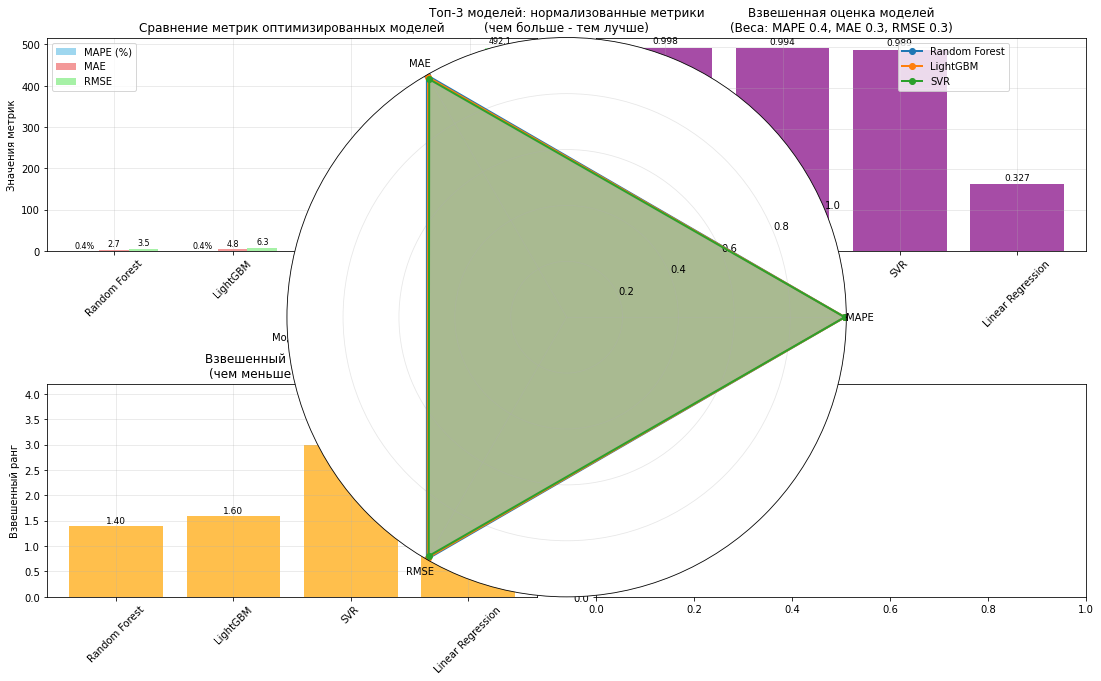


ФИНАЛЬНЫЙ ВЫБОР ЛУЧШЕЙ МОДЕЛИ
РЕЗУЛЬТАТЫ ОЦЕНКИ:
🏆 Лучшая модель по взвешенной оценке: Random Forest
🥈 Лучшая модель по взвешенному рангу: Random Forest
🎯 ЕДИНОГЛАСНОЕ РЕШЕНИЕ: Random Forest

📊 ФИНАЛЬНЫЕ МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ 'Random Forest':
   MAPE: 0.0042 (0.42%)
   MAE:  2.73
   RMSE: 3.55
   Взвешенная оценка: 0.998
   Взвешенный ранг: 1.40

📈 АНАЛИЗ ВКЛАДА МЕТРИК:
   Вклад MAPE:  0.398 (39.9%)
   Вклад MAE:   0.300 (30.0%)
   Вклад RMSE:  0.300 (30.0%)

✅ Процесс завершен!
✅ Лучшая модель 'Random Forest' выбрана по взвешенной оценке трех метрик!


In [19]:
# функция для оценки моделей с кросс-валидацией
def evaluate_model_cv(model, X_train, y_train, model_name, cv=3):
    """Оценка качества модели с кросс-валидацией"""
    
    # Упрощенная кросс-валидация - только MAPE
    cv_scores_mape = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=61025)
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        
        mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)
        cv_scores_mape.append(mape)
    
    # Обучаем модель на всех данных один раз для получения MAE и RMSE
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    metrics = {
        'MAE': mean_absolute_error(y_train, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred)),
        'MAPE': np.mean(cv_scores_mape)
    }
    
    print(f"{model_name}:")
    print(f"  CV MAPE: {metrics['MAPE']:.4f} ({metrics['MAPE']*100:.2f}%)")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    
    return metrics, model

print("=" * 60)
print("ОЦЕНКА БАЗОВЫХ МОДЕЛЕЙ")
print("=" * 60)

# Словарь для хранения результатов
base_results = {}
optimized_results = {}
trained_models = {}

# Модель 1: Линейная регрессия (baseline)
print("\n" + "="*30)
print("Линейная регрессия")
print("="*30)
lr_model = LinearRegression()
lr_base_metrics, lr_model = evaluate_model_cv(lr_model, X_train_scaled, y_train, "Линейная регрессия")
base_results['Linear Regression'] = lr_base_metrics
trained_models['Linear Regression'] = lr_model

# Модель 2: Случайный лес
print("\n" + "="*30)
print("Случайный лес")
print("="*30)
rf_base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_base_metrics, rf_model = evaluate_model_cv(rf_base_model, X_train_scaled, y_train, "Случайный лес")
base_results['Random Forest'] = rf_base_metrics
trained_models['Random Forest'] = rf_model

# Модель 3: SVR
print("\n" + "="*30)
print("SVR")
print("="*30)
svr_base_model = SVR()
svr_base_metrics, svr_model = evaluate_model_cv(svr_base_model, X_train_scaled, y_train, "SVR")
base_results['SVR'] = svr_base_metrics
trained_models['SVR'] = svr_model

# Модель 4: LightGBM (если доступен)
print("\n" + "="*30)
print("LightGBM")
print("="*30)
lgb_base_model = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
lgb_base_metrics, lgb_model = evaluate_model_cv(lgb_base_model, X_train_scaled, y_train, "LightGBM")
base_results['LightGBM'] = lgb_base_metrics
trained_models['LightGBM'] = lgb_model

print("\n" + "="*60)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ")
print("=" * 60)

# Упрощенные сетки параметров
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False]
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [10, 15],
        'min_samples_leaf': [1, 2]
    },
    'SVR': {
        'C': [1, 10],
        'epsilon': [0.1, 0.5]
    },
    'LightGBM': {
        'n_estimators': [50, 100],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1]
    } 
}

# Модели для оптимизации
models_to_optimize = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=61025, n_jobs=-1),
    'SVR': SVR(),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1) 
}

# Подбор гиперпараметров для всех моделей
for model_name, model in models_to_optimize.items():
    print(f"\n" + "="*30)
    print(f"Оптимизация {model_name}")
    print("="*30)
    
    grid = GridSearchCV(
        model,
        param_grids[model_name],
        cv=2,  # Упрощенная кросс-валидация
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train_scaled, y_train)
    print(f"Лучшие параметры: {grid.best_params_}")
    
    # Оцениваем оптимизированную модель
    best_model = grid.best_estimator_
    best_metrics, trained_best_model = evaluate_model_cv(best_model, X_train_scaled, y_train, f"{model_name} (оптимизированный)")
    optimized_results[model_name] = best_metrics
    trained_models[model_name] = trained_best_model

# СРАВНЕНИЕ РЕЗУЛЬТАТОВ
print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

# Создаем DataFrame для сравнения
comparison_data = {}
for model_name in base_results.keys():
    comparison_data[model_name] = {
        'MAPE_base': base_results[model_name]['MAPE'],
        'MAPE_opt': optimized_results[model_name]['MAPE'],
        'MAE_opt': optimized_results[model_name]['MAE'],
        'RMSE_opt': optimized_results[model_name]['RMSE'],
        'Улучшение_MAPE': (base_results[model_name]['MAPE'] - optimized_results[model_name]['MAPE']) * 100,
    }

comparison_df = pd.DataFrame(comparison_data).T

# ВЫБОР ЛУЧШЕЙ МОДЕЛИ ПО ТРЕМ МЕТРИКАМ С ВЕСАМИ
print("\n" + "="*60)
print("ВЫБОР ЛУЧШЕЙ МОДЕЛИ ПО ТРЕМ МЕТРИКАМ")
print("ВЕСА: MAPE (0.4), MAE (0.3), RMSE (0.3)")
print("=" * 60)

def calculate_weighted_score(row, weights={'MAPE': 0.4, 'MAE': 0.3, 'RMSE': 0.3}):
    """
    Вычисляет взвешенную оценку модели
    Метрики нормализуются: чем меньше значение метрики - тем лучше
    """
    # Нормализуем метрики (преобразуем в шкалу, где больше = лучше)
    # Для MAPE: преобразуем в accuracy-like метрику (1 - MAPE)
    mape_score = 1 - row['MAPE_opt']
    
    # Для MAE и RMSE: используем обратные значения (предварительно масштабируем)
    # Находим диапазон значений для нормализации
    mae_range = comparison_df['MAE_opt'].max() - comparison_df['MAE_opt'].min()
    rmse_range = comparison_df['RMSE_opt'].max() - comparison_df['RMSE_opt'].min()
    
    if mae_range > 0:
        mae_score = 1 - (row['MAE_opt'] - comparison_df['MAE_opt'].min()) / mae_range
    else:
        mae_score = 1
    
    if rmse_range > 0:
        rmse_score = 1 - (row['RMSE_opt'] - comparison_df['RMSE_opt'].min()) / rmse_range
    else:
        rmse_score = 1
    
    # Взвешенная сумма
    weighted_score = (weights['MAPE'] * mape_score + 
                     weights['MAE'] * mae_score + 
                     weights['RMSE'] * rmse_score)
    
    return weighted_score

# Добавляем взвешенную оценку
comparison_df['Взвешенная_оценка'] = comparison_df.apply(calculate_weighted_score, axis=1)

# Сортируем по взвешенной оценке (чем выше - тем лучше)
comparison_df = comparison_df.sort_values('Взвешенная_оценка', ascending=False)

print("Сравнение моделей (отсортировано по взвешенной оценке):")
display(comparison_df[['MAPE_opt', 'MAE_opt', 'RMSE_opt', 'Взвешенная_оценка']])

# Альтернативный метод: нормализованные ранги
print("\n" + "="*50)
print("АЛЬТЕРНАТИВНЫЙ МЕТОД: НОРМАЛИЗОВАННЫЕ РАНГИ")
print("="*50)

# Создаем копию для ранжирования
ranking_df = comparison_df.copy()

# Ранжируем по каждой метрике (чем меньше значение - тем лучше ранг)
ranking_df['Ранг_MAPE'] = ranking_df['MAPE_opt'].rank()
ranking_df['Ранг_MAE'] = ranking_df['MAE_opt'].rank()
ranking_df['Ранг_RMSE'] = ranking_df['RMSE_opt'].rank()

# Взвешенный суммарный ранг
ranking_df['Взвешенный_ранг'] = (0.4 * ranking_df['Ранг_MAPE'] + 
                                 0.3 * ranking_df['Ранг_MAE'] + 
                                 0.3 * ranking_df['Ранг_RMSE'])

# Сортируем по взвешенному рангу (чем меньше - тем лучше)
ranking_df = ranking_df.sort_values('Взвешенный_ранг')

print("Ранжирование моделей по взвешенным рангам:")
display(ranking_df[['Ранг_MAPE', 'Ранг_MAE', 'Ранг_RMSE', 'Взвешенный_ранг']])

# Визуализация результатов
plt.figure(figsize=(15, 10))

# График сравнения всех метрик оптимизированных моделей
plt.subplot(2, 2, 1)
models_names = comparison_df.index
mape_opt = comparison_df['MAPE_opt'] * 100
mae_opt = comparison_df['MAE_opt']
rmse_opt = comparison_df['RMSE_opt']

x = np.arange(len(models_names))
width = 0.25

plt.bar(x - width, mape_opt, width, label='MAPE (%)', alpha=0.8, color='skyblue')
plt.bar(x, mae_opt, width, label='MAE', alpha=0.8, color='lightcoral')
plt.bar(x + width, rmse_opt, width, label='RMSE', alpha=0.8, color='lightgreen')

plt.xlabel('Модели')
plt.ylabel('Значения метрик')
plt.title('Сравнение метрик оптимизированных моделей')
plt.xticks(x, models_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (mape, mae, rmse) in enumerate(zip(mape_opt, mae_opt, rmse_opt)):
    plt.text(i - width, mape + max(mape_opt)*0.01, f'{mape:.1f}%', ha='center', va='bottom', fontsize=8)
    plt.text(i, mae + max(mae_opt)*0.01, f'{mae:.1f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width, rmse + max(rmse_opt)*0.01, f'{rmse:.1f}', ha='center', va='bottom', fontsize=8)

# График взвешенной оценки
plt.subplot(2, 2, 2)
weighted_scores = comparison_df['Взвешенная_оценка']

bars = plt.bar(models_names, weighted_scores, alpha=0.7, color='purple')
plt.title('Взвешенная оценка моделей\n(Веса: MAPE 0.4, MAE 0.3, RMSE 0.3)')
plt.ylabel('Взвешенная оценка\n(чем выше - тем лучше)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, weighted_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# График взвешенного ранга
plt.subplot(2, 2, 3)
weighted_ranks = ranking_df['Взвешенный_ранг']

bars = plt.bar(models_names, weighted_ranks, alpha=0.7, color='orange')
plt.title('Взвешенный ранг моделей\n(чем меньше - тем лучше)')
plt.ylabel('Взвешенный ранг')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, weighted_ranks):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2f}', ha='center', va='bottom', fontsize=9)

# Радарная диаграмма для топ-3 моделей с весами
plt.subplot(2, 2, 4)
top_3_models = comparison_df.head(3).index

# Метрики для радарной диаграммы (нормализованные)
labels = ['MAPE', 'MAE', 'RMSE']

for model in top_3_models:
    # Нормализуем метрики для визуализации
    normalized_metrics = [
        1 - comparison_df.loc[model, 'MAPE_opt'],  # 1 - MAPE (чем больше - тем лучше)
        1 - (comparison_df.loc[model, 'MAE_opt'] - comparison_df['MAE_opt'].min()) / 
            (comparison_df['MAE_opt'].max() - comparison_df['MAE_opt'].min() + 1e-8),
        1 - (comparison_df.loc[model, 'RMSE_opt'] - comparison_df['RMSE_opt'].min()) / 
            (comparison_df['RMSE_opt'].max() - comparison_df['RMSE_opt'].min() + 1e-8)
    ]
    
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    normalized_metrics += normalized_metrics[:1]  # Замыкаем диаграмму
    angles += angles[:1]
    
    plt.polar(angles, normalized_metrics, 'o-', linewidth=2, label=model)
    plt.fill(angles, normalized_metrics, alpha=0.25)

plt.thetagrids(np.degrees(angles[:-1]), labels)
plt.title('Топ-3 моделей: нормализованные метрики\n(чем больше - тем лучше)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ФИНАЛЬНЫЙ ВЫБОР ЛУЧШЕЙ МОДЕЛИ
print("\n" + "="*60)
print("ФИНАЛЬНЫЙ ВЫБОР ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

# Выбираем лучшую модель по взвешенной оценке
best_model_weighted = comparison_df.index[0]
best_model_rank = ranking_df.index[0]

print("РЕЗУЛЬТАТЫ ОЦЕНКИ:")
print(f"🏆 Лучшая модель по взвешенной оценке: {best_model_weighted}")
print(f"🥈 Лучшая модель по взвешенному рангу: {best_model_rank}")

# Финальное решение
if best_model_weighted == best_model_rank:
    best_model_name = best_model_weighted
    print(f"🎯 ЕДИНОГЛАСНОЕ РЕШЕНИЕ: {best_model_name}")
else:
    # В случае расхождения выбираем по взвешенной оценке (основной метод)
    best_model_name = best_model_weighted
    print(f"✅ Выбрана {best_model_weighted} (по взвешенной оценке)")

best_model = trained_models[best_model_name]

print(f"\n📊 ФИНАЛЬНЫЕ МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ '{best_model_name}':")
print(f"   MAPE: {comparison_df.loc[best_model_name, 'MAPE_opt']:.4f} ({comparison_df.loc[best_model_name, 'MAPE_opt']*100:.2f}%)")
print(f"   MAE:  {comparison_df.loc[best_model_name, 'MAE_opt']:.2f}")
print(f"   RMSE: {comparison_df.loc[best_model_name, 'RMSE_opt']:.2f}")
print(f"   Взвешенная оценка: {comparison_df.loc[best_model_name, 'Взвешенная_оценка']:.3f}")
print(f"   Взвешенный ранг: {ranking_df.loc[best_model_name, 'Взвешенный_ранг']:.2f}")

# Анализ вклада каждой метрики
print(f"\n📈 АНАЛИЗ ВКЛАДА МЕТРИК:")
mape_contribution = 0.4 * (1 - comparison_df.loc[best_model_name, 'MAPE_opt'])
mae_contribution = 0.3 * (1 - (comparison_df.loc[best_model_name, 'MAE_opt'] - comparison_df['MAE_opt'].min()) / 
                         (comparison_df['MAE_opt'].max() - comparison_df['MAE_opt'].min() + 1e-8))
rmse_contribution = 0.3 * (1 - (comparison_df.loc[best_model_name, 'RMSE_opt'] - comparison_df['RMSE_opt'].min()) / 
                          (comparison_df['RMSE_opt'].max() - comparison_df['RMSE_opt'].min() + 1e-8))

print(f"   Вклад MAPE:  {mape_contribution:.3f} ({(mape_contribution/comparison_df.loc[best_model_name, 'Взвешенная_оценка'])*100:.1f}%)")
print(f"   Вклад MAE:   {mae_contribution:.3f} ({(mae_contribution/comparison_df.loc[best_model_name, 'Взвешенная_оценка'])*100:.1f}%)")
print(f"   Вклад RMSE:  {rmse_contribution:.3f} ({(rmse_contribution/comparison_df.loc[best_model_name, 'Взвешенная_оценка'])*100:.1f}%)")

print(f"\n✅ Процесс завершен!")
print(f"✅ Лучшая модель '{best_model_name}' выбрана по взвешенной оценке трех метрик!")

Вывод по разделу: В данном разделе произвен расчет метрик MAPE, MAE, RMSE на для четырех моделей Линейная регрессия, Случайны лес, Опорные вектора и Градиентный бустинг LightGBM, лучшая модель выбирается после тюнинга гиперпараметров моделей на кросвалидации по ранжированию трех метрик. Лучше всех по метрике MAPE показали себя модели случайного леса и градиентного бустинга, однако у градиентного случайного леса меньше MAE и RMSE поэтому она принята как лучшая.

## 7 Выбор лучшей модели


ФИНАЛЬНАЯ ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ

Random Forest - Финальная оценка на тесте:
MAPE: 0.0042 (0.42%)
MAE: 6.71
RMSE: 9.00
Доступные колонки в comparison_df: ['MAPE_base', 'MAPE_opt', 'MAE_opt', 'RMSE_opt', 'Улучшение_MAPE', 'Взвешенная_оценка']


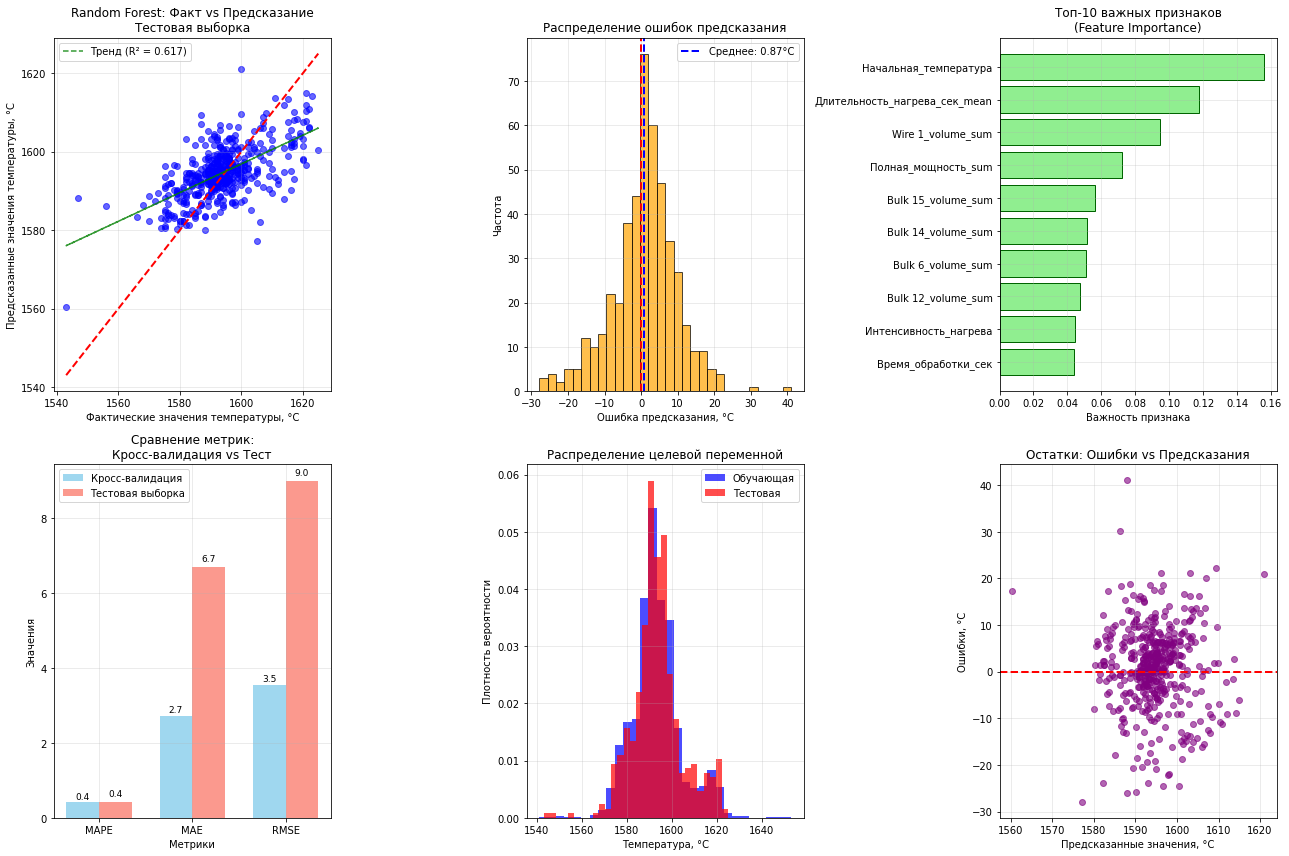


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ДЛЯ ЛУЧШЕЙ МОДЕЛИ

Топ-10 наиболее важных признаков для модели Random Forest:


,feature,importance
11,Начальная_температура,0.155713
18,Длительность_нагрева_сек_mean,0.117883
7,Wire 1_volume_sum,0.094874
6,Полная_мощность_sum,0.072293
12,Bulk 15_volume_sum,0.056366
20,Bulk 14_volume_sum,0.051464
9,Bulk 6_volume_sum,0.051052
19,Bulk 12_volume_sum,0.047432
23,Интенсивность_нагрева,0.044454
8,Время_обработки_сек,0.044187



КАТЕГОРИИ ВАЖНЫХ ПРИЗНАКОВ:
• Температурные параметры: 1 признаков
• Параметры нагрева: 3 признаков
• Материалы и добавки: 5 признаков
• Временные параметры: 2 признаков
• Другие параметры: 0 признаков

ИНТЕРПРЕТАЦИЯ ДЛЯ ТЕХНОЛОГОВ:
Наиболее значимые факторы: Начальная_температура, Длительность_нагрева_сек_mean, Wire 1_volume_sum

СРАВНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ И ТЕСТОВОЙ ВЫБОРКИ
MAPE на кросс-валидации: 0.42%
MAPE на тестовой выборке: 0.42%
Разница: 0.01%
✓ Модель показывает стабильные результаты на разных выборках

ДОПОЛНИТЕЛЬНАЯ АНАЛИТИКА
Средняя абсолютная ошибка: 6.71°C
Среднеквадратичная ошибка: 9.00°C
Точность предсказания: 99.58%
✓ Отличное качество модели (MAPE < 5%)

ОБУЧЕНИЕ И ОЦЕНКА ЗАВЕРШЕНЫ!


In [20]:
print("\n" + "="*80)
print("ФИНАЛЬНАЯ ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)

# Оцениваем лучшую модель на тестовых данных
def evaluate_final_model(model, X_test, y_test, model_name):
    """Финальная оценка лучшей модели на тестовой выборке"""
    y_pred_test = model.predict(X_test)
    
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred_test)
    }
    
    print(f"\n{model_name} - Финальная оценка на тесте:")
    print(f"MAPE: {metrics['MAPE']:.4f} ({metrics['MAPE']*100:.2f}%)")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    
    return metrics, y_pred_test

final_metrics, y_pred_test = evaluate_final_model(best_model, X_test_scaled, y_test, best_model_name)

# СОЗДАЕМ ВИЗУАЛИЗАЦИЮ С АНАЛИЗОМ ПРИЗНАКОВ
fig = plt.figure(figsize=(18, 12))

# 1. График факт vs предсказание
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения температуры, °C')
plt.ylabel('Предсказанные значения температуры, °C')
plt.title(f'{best_model_name}: Факт vs Предсказание\nТестовая выборка')
plt.grid(True, alpha=0.3)

# Добавляем линию тренда
z = np.polyfit(y_test, y_pred_test, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "g--", alpha=0.8, label=f'Тренд (R² = {np.corrcoef(y_test, y_pred_test)[0,1]:.3f})')
plt.legend()

# 2. График ошибок предсказания
plt.subplot(2, 3, 2)
errors = y_pred_test - y_test
plt.hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Ошибка предсказания, °C')
plt.ylabel('Частота')
plt.title('Распределение ошибок предсказания')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.axvline(x=errors.mean(), color='blue', linestyle='--', linewidth=2, label=f'Среднее: {errors.mean():.2f}°C')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
plt.subplot(2, 3, 3)

# Определяем важность признаков в зависимости от типа модели
feature_importance_df = None

# Получаем названия признаков
features = X_train_scaled.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    # Для моделей с feature_importances_ (Random Forest, LightGBM)
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': feature_importance
    }).sort_values('importance', ascending=True).tail(10)  # Берем топ-10
    
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
             color='lightgreen', edgecolor='darkgreen')
    plt.xlabel('Важность признака')
    plt.title('Топ-10 важных признаков\n(Feature Importance)')
    
elif hasattr(best_model, 'coef_'):
    # Для линейных моделей
    coefficients = best_model.coef_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': np.abs(coefficients)
    }).sort_values('importance', ascending=True).tail(10)
    
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'],
             color='lightblue', edgecolor='darkblue')
    plt.xlabel('Абсолютное значение коэффициента')
    plt.title('Топ-10 важных признаков\n(Коэффициенты модели)')
    
else:
    # Для моделей без явной важности признаков (SVR)
    from sklearn.inspection import permutation_importance
    
    perm_importance = permutation_importance(best_model, X_test_scaled, y_test, 
                                           n_repeats=10, random_state=42, n_jobs=-1)
    
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=True).tail(10)
    
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'],
             color='lightcoral', edgecolor='darkred')
    plt.xlabel('Важность (permutation importance)')
    plt.title('Топ-10 важных признаков\n(Permutation Importance)')

plt.grid(True, alpha=0.3)

# 4. Сравнение метрик на кросс-валидации и тесте
plt.subplot(2, 3, 4)
metrics_comparison = ['MAPE', 'MAE', 'RMSE']

# Используем правильные названия колонок из comparison_df
print("Доступные колонки в comparison_df:", comparison_df.columns.tolist())

# Исправляем названия колонок в соответствии с comparison_df
cv_values = [
    comparison_df.loc[best_model_name, 'MAPE_opt'] * 100,  # MAPE в %
    comparison_df.loc[best_model_name, 'MAE_opt'],         # MAE
    comparison_df.loc[best_model_name, 'RMSE_opt']         # RMSE
]

test_values = [
    final_metrics['MAPE'] * 100,  # MAPE в %
    final_metrics['MAE'],         # MAE
    final_metrics['RMSE']         # RMSE
]

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = plt.bar(x - width/2, cv_values, width, label='Кросс-валидация', alpha=0.8, color='skyblue')
bars2 = plt.bar(x + width/2, test_values, width, label='Тестовая выборка', alpha=0.8, color='salmon')

plt.xlabel('Метрики')
plt.ylabel('Значения')
plt.title('Сравнение метрик:\nКросс-валидация vs Тест')
plt.xticks(x, metrics_comparison)
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (cv, test) in enumerate(zip(cv_values, test_values)):
    plt.text(i - width/2, cv + max(cv_values)*0.01, f'{cv:.1f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, test + max(test_values)*0.01, f'{test:.1f}', ha='center', va='bottom', fontsize=9)

# 5. Распределение целевой переменной
plt.subplot(2, 3, 5)
plt.hist(y_train, bins=30, alpha=0.7, label='Обучающая', color='blue', density=True)
plt.hist(y_test, bins=30, alpha=0.7, label='Тестовая', color='red', density=True)
plt.xlabel('Температура, °C')
plt.ylabel('Плотность вероятности')
plt.title('Распределение целевой переменной')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. График остатков (ошибки vs предсказания)
plt.subplot(2, 3, 6)
plt.scatter(y_pred_test, errors, alpha=0.6, color='purple')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Предсказанные значения, °C')
plt.ylabel('Ошибки, °C')
plt.title('Остатки: Ошибки vs Предсказания')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ВЫВОДИМ ТАБЛИЦУ ВАЖНЫХ ПРИЗНАКОВ
print("\n" + "="*80)
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ДЛЯ ЛУЧШЕЙ МОДЕЛИ")
print("="*80)

if feature_importance_df is not None:
    print(f"\nТоп-10 наиболее важных признаков для модели {best_model_name}:")
    display(feature_importance_df.sort_values('importance', ascending=False))
    
    # Анализ влияния признаков
    print("\nКАТЕГОРИИ ВАЖНЫХ ПРИЗНАКОВ:")
    
    # Группируем признаки по категориям
    temperature_related = [f for f in feature_importance_df['feature'] if 'температур' in f.lower() or 'амплитуд' in f.lower() or 'temp' in f.lower()]
    power_related = [f for f in feature_importance_df['feature'] if 'мощност' in f.lower() or 'нагрев' in f.lower() or 'power' in f.lower()]
    material_related = [f for f in feature_importance_df['feature'] if 'объем' in f.lower() or 'bulk' in f.lower() or 'wire' in f.lower() or 'материал' in f.lower()]
    time_related = [f for f in feature_importance_df['feature'] if 'время' in f.lower() or 'длительность' in f.lower() or 'time' in f.lower()]
    
    other_related = [f for f in feature_importance_df['feature'] if f not in temperature_related + power_related + material_related + time_related]
    
    print(f"• Температурные параметры: {len(temperature_related)} признаков")
    print(f"• Параметры нагрева: {len(power_related)} признаков")
    print(f"• Материалы и добавки: {len(material_related)} признаков")
    print(f"• Временные параметры: {len(time_related)} признаков")
    print(f"• Другие параметры: {len(other_related)} признаков")
    
    # Интерпретация для бизнеса
    print("\nИНТЕРПРЕТАЦИЯ ДЛЯ ТЕХНОЛОГОВ:")
    top_3_features = feature_importance_df.nlargest(3, 'importance')['feature'].tolist()
    print(f"Наиболее значимые факторы: {', '.join(top_3_features)}")
    
else:
    print("Не удалось определить важность признаков для данной модели")

# Сравнение результатов кросс-валидации и тестовой выборки
print("\n" + "="*80)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ И ТЕСТОВОЙ ВЫБОРКИ")
print("="*80)

cv_mape = comparison_df.loc[best_model_name, 'MAPE_opt'] * 100
test_mape = final_metrics['MAPE'] * 100

print(f"MAPE на кросс-валидации: {cv_mape:.2f}%")
print(f"MAPE на тестовой выборке: {test_mape:.2f}%")
print(f"Разница: {abs(cv_mape - test_mape):.2f}%")

if abs(cv_mape - test_mape) < 1.0:
    print("✓ Модель показывает стабильные результаты на разных выборках")
else:
    print("⚠ Возможно переобучение или нестабильность модели")

# Дополнительная аналитика
print("\n" + "="*80)
print("ДОПОЛНИТЕЛЬНАЯ АНАЛИТИКА")
print("="*80)

print(f"Средняя абсолютная ошибка: {final_metrics['MAE']:.2f}°C")
print(f"Среднеквадратичная ошибка: {final_metrics['RMSE']:.2f}°C")
print(f"Точность предсказания: {(1 - final_metrics['MAPE']) * 100:.2f}%")

# Анализ качества модели
if final_metrics['MAPE'] < 0.05:
    print("✓ Отличное качество модели (MAPE < 5%)")
elif final_metrics['MAPE'] < 0.1:
    print("✓ Хорошее качество модели (MAPE < 10%)")
elif final_metrics['MAPE'] < 0.2:
    print("⚠ Удовлетворительное качество модели (MAPE < 20%)")
else:
    print("⚠ Низкое качество модели (MAPE ≥ 20%)")

print("\n" + "="*80)
print("ОБУЧЕНИЕ И ОЦЕНКА ЗАВЕРШЕНЫ!")
print("="*80)

Вывод по разделу: В 7 разделе произведена проверка лучшей модели на тестовых данных.MAPE на тестовых данных оказалось 0.42% что свидетельствует о высоком качестве модели. Средне абсолютная и квадратичная ошибки составляют 6.71 и 9.00 градуса что выше чем на тренировочных данных но вполне достаточно. Самыми важными признаками для модели являются начальная температура,  мощность, длительность нагрева использование 1 провлочного и 15,12,14,6 сыпучих материалов

## Общий вывод и рекомендации заказчику

Общий вывод:
* В первом разделе производилась загрузка данных и первичный осмотр из которого можно сделать выводы:
1) Датафрейм Нагрев дугой data_arc_new имеет 14876 записей без пропусков. Содержит данные по ключам которые повторяются всего их 3241, и мощностям активной и реактивной. В значении реактивной мощности содержатся аномалии минимальное значение -715 при среднем 0.43.
2) Датафрейм сыпучие материалы обьем содержит 3129 строк и 16 столбцов, ключ и 15 сыпучих компонентов по разному скомбинированных. Есть компоненты которые используются почти всегда 12,14,15 и всего один раз 8.
3) Датафрейм сыпучие матераилы время содержит дополнение к предыдущему датафрейму у них общий ключ, одинаковое количетсво строк и количество пропусков в сыпучих компанентов.
4) Датафрейм продувка газом имеет 3239 строк и два столбца ключ и газ1 без явных выбросов, однако интерсно проверить его на дубликаты так как строк отличается от предыдущего, может для одного ключа несколько продувок или дубликаты
5) Датафрейм температура имеет 18092 и значения ключа, время замера и температуры, для одного ключа имеется нисколько замеров
6) Датафрейм проволочные матеиалы Обьем содержит 3081 строку и столбцы ключ и 9 проволочных материалов. При этом  восновном использовали 1 материал и 1 раз 5 материал, меньше 100 раз 3,4,5,6,7,8,9
7) Датафрейм проволочные материалы время содержит дополнения к предыдущему датафрейму у них общий ключ, одинаковое количетсво строк и количество пропусков в проволочных материалов.
8) Общим среди всех данных является столбец ключ key всего из 3241, в некоторых данных они повторяются т.к. замеры делались для одной партии. При этом значений используется от 3081 и 3129 до 18092. По некоторым партиям данные отсутсвую.
* Во втором разделе производился исследовательский анализ и предобработк данных после которого можно сделать выводы:
1) Сразу обьеденим два датафрейма по выпучим и проволоным материалам для удобства
2) В данных отсутсвуют полные дубликаты
3) В данных о нагреву трубой приствует аномалия отрицательная реактивная мощность заменим ее средним значением по партии(key)
4) Данные о нагреву трубой, о продувке газом и даные о температуре агрегируем по партиям(key) для того чтобы в дальнейшем обьединить в одну таблицу
* В третьем разделе производилось обьединение данных в один датафрейм осле обьединения датафреймов по столбцу key получится один с 3241 строками и 100 столбцами. 
* В четвертом разделе производился анализ и предобратботка обьединенного датафрейма в процессе можно сделать выводы:
1) После обьединения было удалено 194 строки с пропусками и произведен кореляционный анализ с целевой переменной конечная температура. 
2) В признаки были дополнительно добавлены Интенсивность_нагрева как мощность деленная на время, интенсивность подачи сыпучих как обьем деленный на время, интенсивность подачи проволки  как обьем деленный на время, эффективность нагрева как разница температур поделенная на мощность
3) Из анализа мультилонеарности Минимальная_температура сильно коррелирует с Начальная_температура (r = 0.885), Количество_замеров сильно коррелирует с - Время_обработки_сек (r = 0.779), Bulk 12_volume_sum сильно коррелирует с
Средний_объем_сыпучих_за_подачу (r = 0.851) и - Общий_объем_сыпучих (r = 0.851), Общий_объем_проволоки сильно коррелирует с:
Средний_объем_проволоки_за_подачу (r = 1.000), Длительность_нагрева_сек_count сильно коррелирует с: - Активная мощность_sum (r = 0.886) и   - Полная_мощность_sum (r = 0.885)
4) Самыми выскоми кореляциями с целевым признаком обладает начальная температура и максимальная температура
5) Предложен финальный датасет для анализа моделей состоящий из 3241 строки и 33 столбцов
* В пятом разделе производилась пподготовка даных для обучения по завершению которого можно сделать выводы:
1)В датасете присутвуют пять столбцов ключ и 4 темпеартуры с колинеарностью к целевой переменной котоыре нужно удалить служебный key, а также конечная и начальная температура
2)Датасет разделим на тренировочный 80% и тестовый 20% для расчета метрик работы
3) Также в данном разделе произвдено масштабирование признаков с помощью RobustScaler т.к. он устойчив к выбросам
4) Из призноков удалены два с нулевой дисперсией Количество_подач_сыпучих, Количество_подач_проволоки, что логчино потомучто они мультиколинеарны с интенсивностью подачи
5) Также из признаков логчино удалть время нагрева и обьем газа т.к. эти переменные прямо влияют на темпеартур логичнее их заменить расходом газа как обеьм поделить на время
* В шестом разделе произвен расчет метрик MAPE, MAE, RMSE на для четырех моделей Линейная регрессия, Случайны лес, Опорные вектора и Градиентный бустинг LightGBM, лучшая модель выбирается после тюнинга гиперпараметров моделей на кросвалидации по ранжированию трех метрик. Лучше всех по метрике MAPE показали себя модели случайного леса и градиентного бустинга, однако у случайного леса заметно меньше MAE и RMSE поэтому она принята как лучшая.
* В седьмом разделе произведена проверка лучшей модели на тестовых данных.MAPE на тестовых данных оказалось 0.42% что свидетельствует о высоком качестве модели. Средне абсолютная и квадратичная ошибки составляют 6.71 и 9.00 градуса что выше чем на тренировочных данных но вполне достаточно. Самыми важными признаками для модели являются начальная температура,  мощность, длительность нагрева использование 1 провлочного и 15,12,14,6 сыпучих материалов

Задача бизнеса звучит как построить модель которая будет предсказывать температуру сплава. На основании проделанной работы можно предложить для бизнеса:
* Изза дисбаланса данных по сыпучим и проволочным материалам модель зависит от обьема первого проволочного  и 15,12,14,6 сыпучих материала. Для бизнеса это принципиально использовать материалы дающие большую темпеартуру
* Самым влиятельным признаком моджели влиящим на целевую переменную оказалась начальная температура что очень логично т.к. целевая переменаая связана с ней амплитудой
* Вторым признаком влиящим на модель оказалась длительность нагрева, что вполне логично
* Также выжным для модели оказалась полная мощность. Для бизнеса лучше использовать удельную мощность нагрева как полную поделить на амплитуду температур.
* Важнейшим признак будет зависит от задачи например если бизнесу интересна комбинация материалов которые дают выше температуру и меньший расход теплоты и газа то акцент надос делать на материалах. Если же например задача экономии мощности то лучше вести удельную мощность как отношение полной на время нагрева или же экономия газа для этого улчше ввести расход газа как отношения обьема газа к продолжительности.

